# <제주렌트카 가격예측 회귀 프로젝트>

## 1. 주제 선정

- 코로나 이슈 이후 제주도 렌트카 가격이 급증하고있다.
- 올 여름 제주여행에 대비해, 렌트카 가격을 미리 예측하여 가성비갑 여행을 해보자!
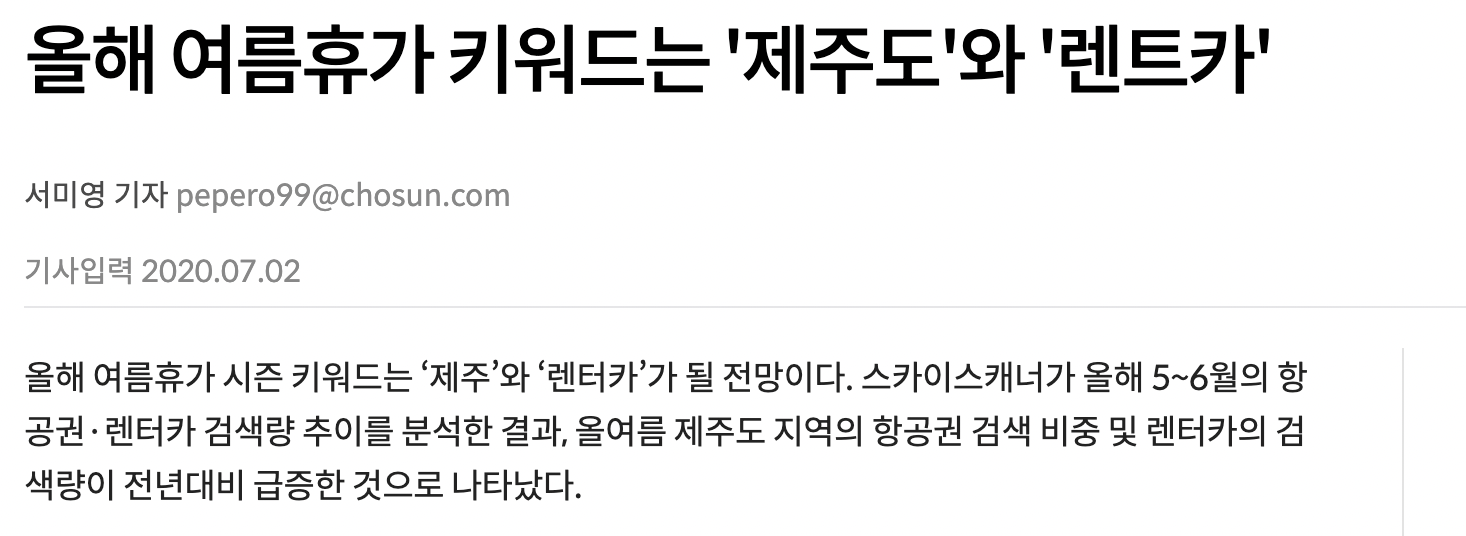
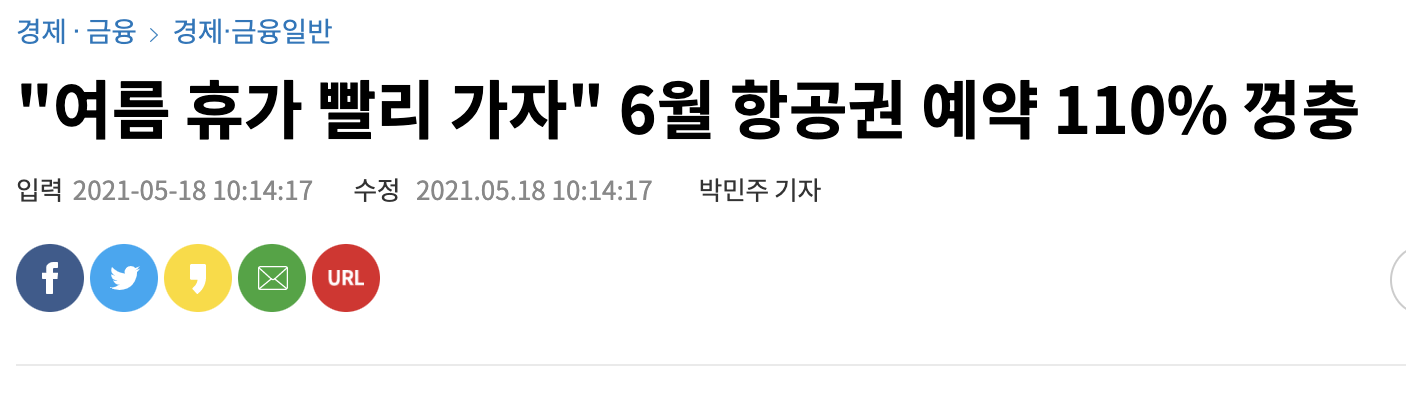

---

## 2. 데이터 설명

### 2-1. 데이터 출처
- 데이터 수집 사이트 : 제주패스랜트카
- 수집기간 : 6월~10월
- 수집방법 : 크롤링(selenium, bs4)

### 2-2. 주요 변수

### 1개의 row 데이터 도식화
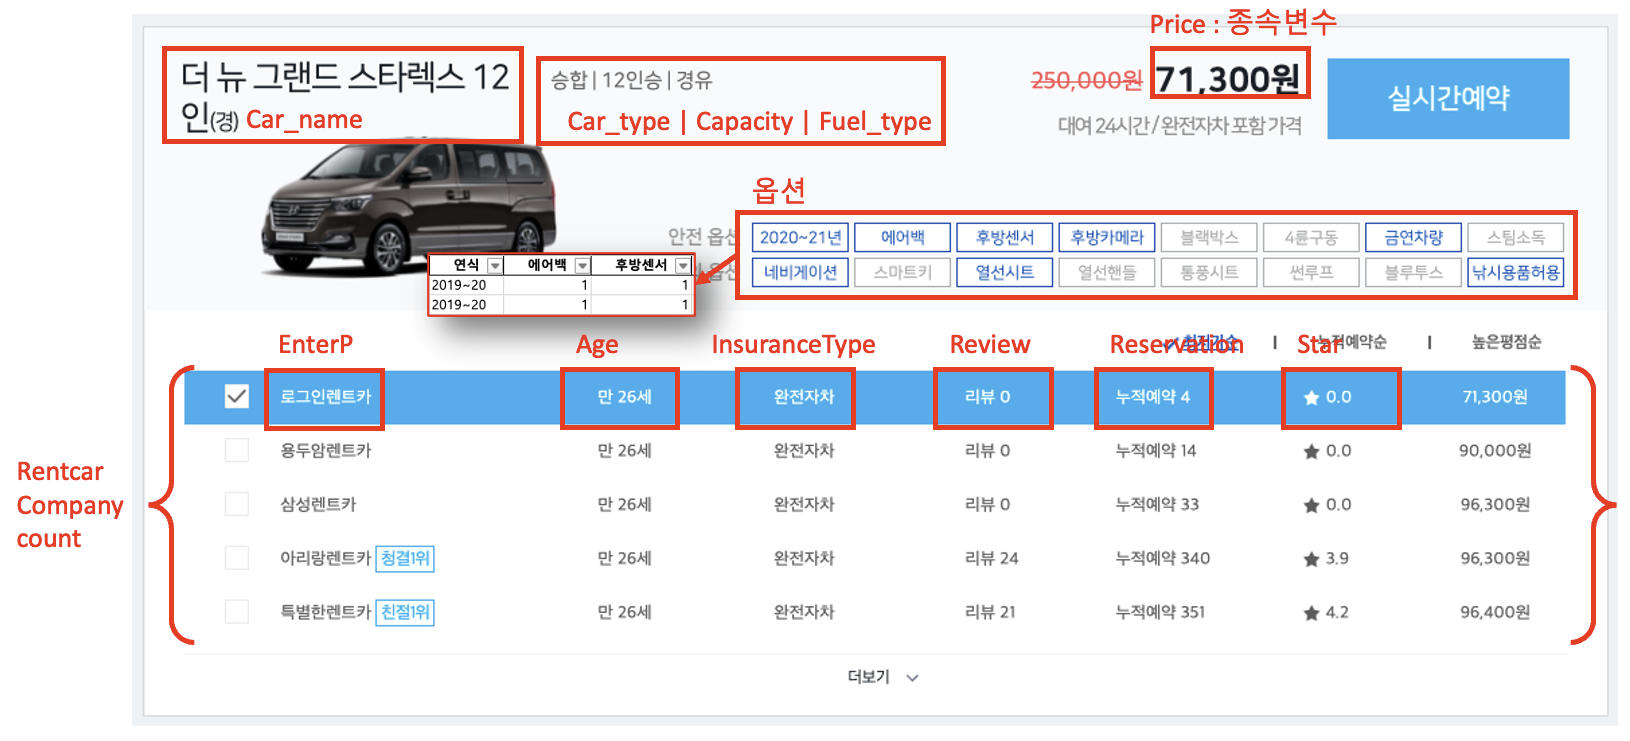
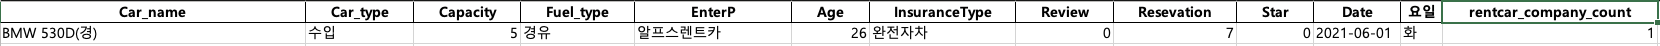

### 독립변수(17개)  / 주요 독립변수 : "차량가격"
- 모델명 | 세그먼트 | 수용인원 | 연료타입 | 제공업체 | 랜트가능 최소 연령 |
- 보험종류 | 리뷰수 | 누적예약수 | 별점 | 일자 | 요일 | 취급렌트카수 | 연식 |
- 옵션종류 | 월 | 차량가격


### 종속변수
- 하루 렌트 가격

---

### 사전준비

#### 활용 패키지 import

In [1]:
#모듈 추가
import pandas as pd
print("pandas version: ", pd.__version__)
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 1000)
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import re
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import warnings
import rise
warnings.filterwarnings(action='ignore')

# 팔레트

#기본
palette1 = sns.color_palette('pastel')

#범주형
categorical = sns.color_palette('Set3', 10)

#연속형1
sbys = sns.color_palette('RdBu', 10)

#연속형2
sequential = sns.color_palette("GnBu", 10)


# 폰트
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

pandas version:  1.2.4


#### 편의를 위한 함수 정의

In [2]:

def create_range_data(df, col, bins_start, bins_end, bins_jump):
    df[f'{col}_range'] = pd.cut(df[f'{col}'],
                               bins=range(bins_start,bins_end+1,bins_jump),
                               include_lowest=True,
                               labels=range(bins_start+bins_jump,bins_end+1,bins_jump))
    
def drop_col(df, col):
    df.drop([f'{col}_range'], axis=1, inplace=True)

#### 데이터 불러오기

In [3]:
#데이터 읽기

jejurent_df = pd.read_excel("./jeju_Rev5.xlsx")
jejurent_df

Car_name Car_type  Capacity Fuel_type   EnterP  Age  \
0                   BMW 530D(경)       수입         5        경유   알프스렌트카   26   
1             벤츠 E220D 카브리올레(경)       수입         5        경유    예스렌트카   26   
2                   제네시스 G90(휘)       고급         5       휘발유  제주OK렌트카   26   
3              BMW 430i 컨버터블(휘)       수입         4       휘발유  제주다움렌트카   26   
4      테슬라모델3 퍼포먼스 EV(전기/충전비유료)       수입         5       전기차   퍼시픽렌트카   26   
...                         ...      ...       ...       ...      ...  ...   
21144       테슬라모델3 EV(전기/충전비유료)       수입         5       전기차   퍼스트렌트카   26   
21145                볼보 S90 (휘)       수입         5       휘발유   퍼스트렌트카   26   
21146          BMW 430i 컨버터블(휘)       수입         4       휘발유   퍼스트렌트카   26   
21147           BMW Z4 컨버터블 (휘)       수입         2       휘발유   퍼스트렌트카   26   
21148          A5 카브리올레 TFSI(휘)       수입         4       휘발유   퍼스트렌트카   26   

      InsuranceType  Review  Resevation  Star        Date 요일  \
0              완전자차       0           7   0.0  2021-06-01  화   
1              완전자차       2          20   3.1  2021-06-01  화   
2             부분무제한       0           7   0.0  2021-06-01  화   
3              완전자차       1          27   5.0  2021-06-01  화   
4             슈퍼무제한       1          17   4.3  2021-06-01  화   
...             ...     ...         ...   ...         ... ..   
21144          완전자차       8         233   3.7  2021-10-30  토   
21145          완전자차       0           9   0.0  2021-10-30  토   
21146          완전자차       3          24   4.8  2021-10-30  토   
21147          완전자차       1           5   4.6  2021-10-30  토   
21148          완전자차       0           1   0.0  2021-10-30  토   

       rentcar_company_count       연식  에어백  후방센서  후방카메라  블랙박스  4륜구동  금연차량  \
0                          1  2019~20    1     1      1     1     0     1   
1                          1  2019~20    1     1      1     0     0     1   
2                          2  2019~20    1     1      1     0     0     1   
3                          3  2020~21    1     1      1     1     0     1   
4                          1  2020~21    1     1      1     1     1     1   
...                      ...      ...  ...   ...    ...   ...   ...   ...   
21144                      1  2020~21    1     1      1     0     0     1   
21145                      1  2021~22    1     1      1     1     1     1   
21146                      1  2020~21    1     1      1     1     0     1   
21147                      1  2021~22    1     1      1     1     0     1   
21148                      1  2021~22    1     1      1     1     1     1   

       스팀소독  네비게이션  스마트키  열선시트  열선핸들  통풍시트  썬루프  블루투스  낚시용품허용  Month  \
0         1      1     1     1     1     1    1     1       0      6   
1         1      1     1     1     0     0    0     1       0      6   
2         0      1     1     1     1     1    0     1       0      6   
3         0      1     1     1     0     0    0     1       0      6   
4         1      1     1     1     0     0    0     1       0      6   
...     ...    ...   ...   ...   ...   ...  ...   ...     ...    ...   
21144     0      1     1     1     1     0    0     1       0     10   
21145     0      1     1     1     1     1    1     1       0     10   
21146     0      1     1     1     1     1    0     1       0     10   
21147     0      1     1     1     0     0    0     1       0     10   
21148     0      1     1     1     1     1    0     1       0     10   

       Car_price   Price  
0       85000000  279600  
1       80300000  472000  
2       79070000  320500  
3       76500000  378900  
4       74790000  378000  
...          ...     ...  
21144   54790000  446100  
21145   59490000  446100  
21146   76500000  531000  
21147   66400000  531000  
21148   75660000  531000  

[21149 rows x 32 columns]

---

## 3. 데이터 전처리

### 독립변수 가공

#### 추가 독립변수 1 : "평일/휴일"
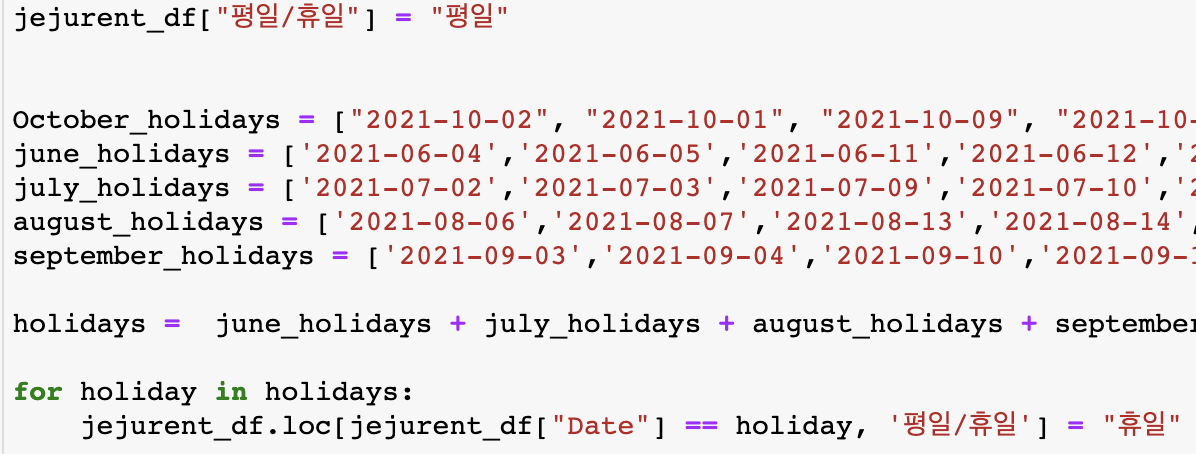
- 평일과 휴일을 여행수요가 증가할 것으로 예상되는 요일과 날짜를 기준으로 나누었다.
    - 월,화,수,목,일 : 평일
    - 금,토 & 공휴일 & 공휴일과 주말 사이의 평일 : 휴일
    






#### 추가 독립변수 2 : "성수기/비성수기"
##### 월별 가격 변동 그래프


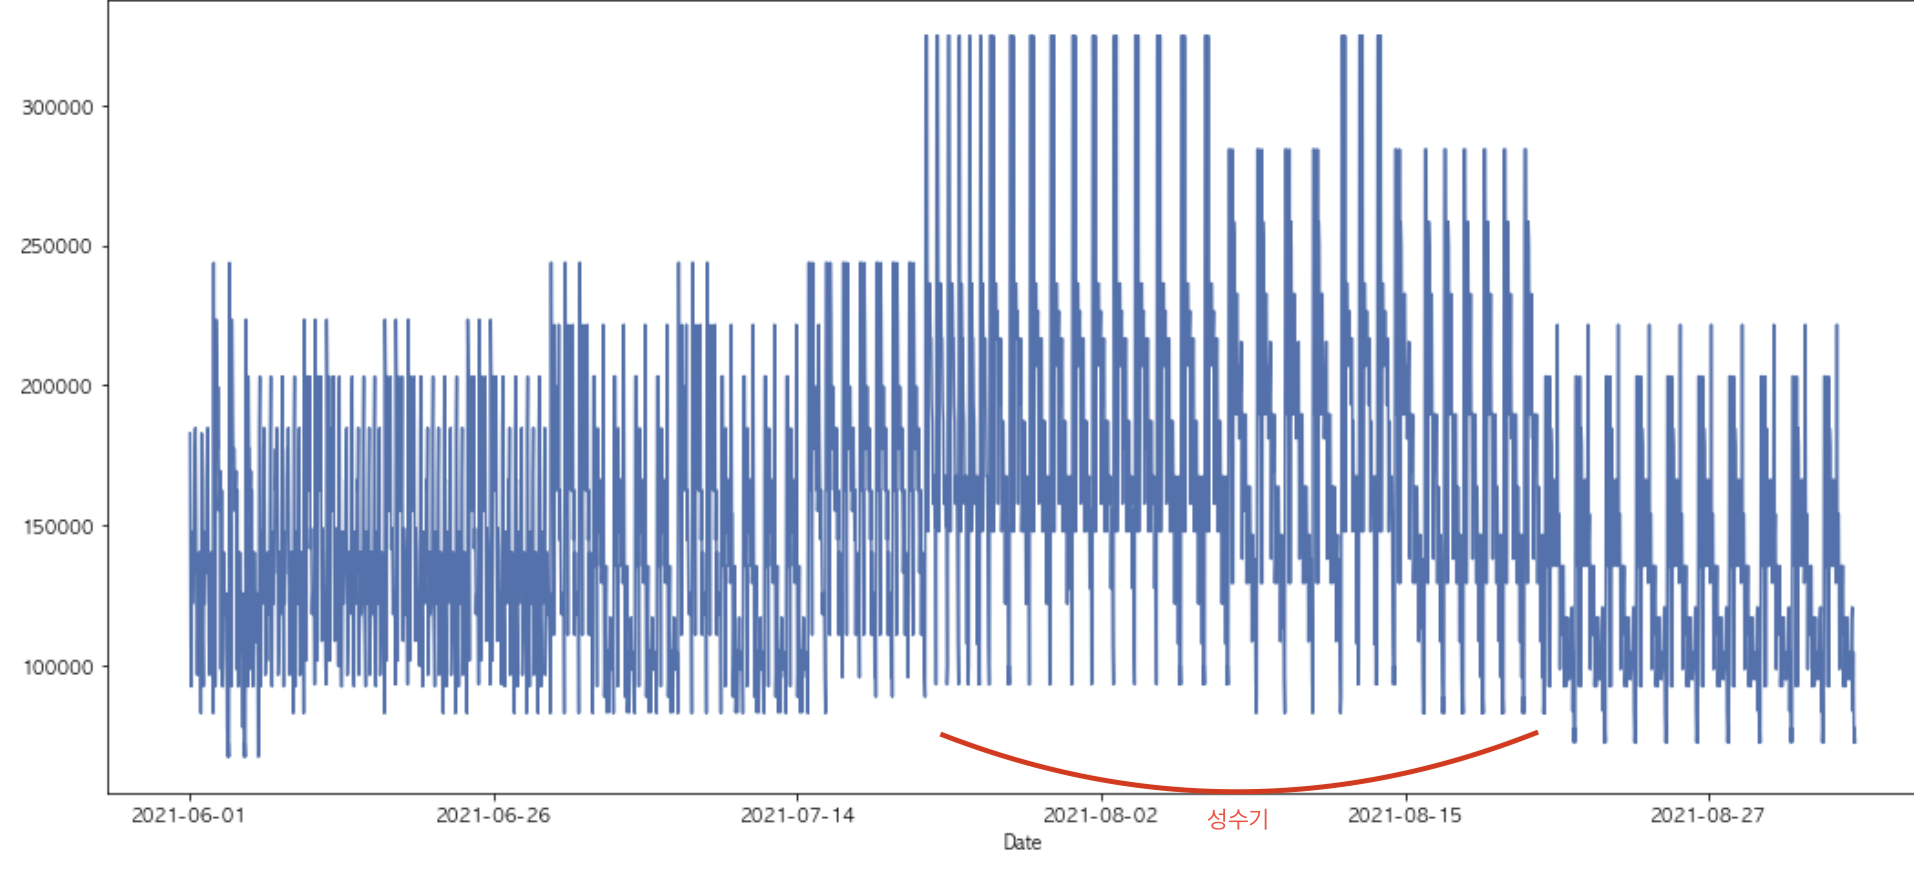

- 차종마다 상이하지만 평균적으로 가격이 가장 높은 7월 15일부터 35일간 성수기로 정했다.

#### 수정한 독립변수 1 : "옵션개수"
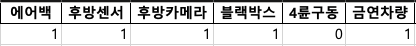
- 옵션의 유무로 1,0 으로 표현을 했지만 독립변수가 너무 많아진다.
- 해당 변수들을 다 지우고 "옵션개수" 변수를 추가해서 대체한다.

#### 수정한 독립변수 2 : "연식"
- 크롤링 과정에서 값이 "2019~20연식"의 문자열로 저장됨.
- Regression을 위해 수치형 데이터로 변경 : "2019~20연식" -> "2019"

In [4]:
#평일/휴일 컬럼 추가
# 추가 이유 : 평일과 휴일(주말, 공휴일)에 따라 렌트카의 가격프리미엄이 붙는다.
jejurent_df["평일/휴일"] = "평일"


October_holidays = ["2021-10-02", "2021-10-01", "2021-10-09", "2021-10-08", "2021-10-15", "2021-10-16", "2021-10-22", "2021-10-23", "2021-10-29", "2021-10-30"]
june_holidays = ['2021-06-04','2021-06-05','2021-06-11','2021-06-12','2021-06-18','2021-06-19','2021-06-25','2021-06-26']
july_holidays = ['2021-07-02','2021-07-03','2021-07-09','2021-07-10','2021-07-16','2021-07-17','2021-07-23','2021-07-24','2021-07-30','2021-07-31']
august_holidays = ['2021-08-06','2021-08-07','2021-08-13','2021-08-14','2021-08-20','2021-08-21','2021-08-27','2021-08-28']
september_holidays = ['2021-09-03','2021-09-04','2021-09-10','2021-09-11','2021-09-17','2021-09-18','2021-09-19','2021-09-20','2021-09-21','2021-09-22','2021-09-23','2021-09-24','2021-09-25']

holidays =  june_holidays + july_holidays + august_holidays + september_holidays + October_holidays

for holiday in holidays:
    jejurent_df.loc[jejurent_df["Date"] == holiday, '평일/휴일'] = "휴일"
    

    
    
# 성수기 라벨링(07-15~08-18) 

import datetime
import time

vac_season = []
times = datetime.date(2021, 7, 15)
for i in range(35):
    vac_season.append(times.strftime('%Y-%m-%d'))
    times += datetime.timedelta(days=1)
    
jejurent_df["성수기/비성수기"] = 0

for day in vac_season:
    jejurent_df.loc[jejurent_df["Date"] == day, '성수기/비성수기'] = 1

    
    
# 옵션 카운트컬럼 적용 및 옵션 컬럼 삭제
for i in range(15,29):
    jejurent_df[jejurent_df.columns[14]] += jejurent_df[jejurent_df.columns[i]]
jejurent_df.drop(columns=jejurent_df.columns[15:29], axis=1, inplace=True)
jejurent_df.rename(columns={"에어백":"옵션개수"}, inplace=True)    
    
    
    

#연식 컬럼 수정 (2020~21 -> 2020)
car_age_ls = []
for car_age in list(jejurent_df["연식"]):
    car_age_ls.append(car_age[0:4])

jejurent_df["연식"] = car_age_ls

In [5]:
# 전처리한 데이터셋
jejurent_df

Car_name Car_type  Capacity Fuel_type   EnterP  Age  \
0                   BMW 530D(경)       수입         5        경유   알프스렌트카   26   
1             벤츠 E220D 카브리올레(경)       수입         5        경유    예스렌트카   26   
2                   제네시스 G90(휘)       고급         5       휘발유  제주OK렌트카   26   
3              BMW 430i 컨버터블(휘)       수입         4       휘발유  제주다움렌트카   26   
4      테슬라모델3 퍼포먼스 EV(전기/충전비유료)       수입         5       전기차   퍼시픽렌트카   26   
...                         ...      ...       ...       ...      ...  ...   
21144       테슬라모델3 EV(전기/충전비유료)       수입         5       전기차   퍼스트렌트카   26   
21145                볼보 S90 (휘)       수입         5       휘발유   퍼스트렌트카   26   
21146          BMW 430i 컨버터블(휘)       수입         4       휘발유   퍼스트렌트카   26   
21147           BMW Z4 컨버터블 (휘)       수입         2       휘발유   퍼스트렌트카   26   
21148          A5 카브리올레 TFSI(휘)       수입         4       휘발유   퍼스트렌트카   26   

      InsuranceType  Review  Resevation  Star        Date 요일  \
0              완전자차       0           7   0.0  2021-06-01  화   
1              완전자차       2          20   3.1  2021-06-01  화   
2             부분무제한       0           7   0.0  2021-06-01  화   
3              완전자차       1          27   5.0  2021-06-01  화   
4             슈퍼무제한       1          17   4.3  2021-06-01  화   
...             ...     ...         ...   ...         ... ..   
21144          완전자차       8         233   3.7  2021-10-30  토   
21145          완전자차       0           9   0.0  2021-10-30  토   
21146          완전자차       3          24   4.8  2021-10-30  토   
21147          완전자차       1           5   4.6  2021-10-30  토   
21148          완전자차       0           1   0.0  2021-10-30  토   

       rentcar_company_count    연식  옵션개수  Month  Car_price   Price 평일/휴일  \
0                          1  2019    13      6   85000000  279600    평일   
1                          1  2019     9      6   80300000  472000    평일   
2                          2  2019    10      6   79070000  320500    평일   
3                          3  2020     9      6   76500000  378900    평일   
4                          1  2020    11      6   74790000  378000    평일   
...                      ...   ...   ...    ...        ...     ...   ...   
21144                      1  2020     9     10   54790000  446100    휴일   
21145                      1  2021    13     10   59490000  446100    휴일   
21146                      1  2020    11     10   76500000  531000    휴일   
21147                      1  2021     9     10   66400000  531000    휴일   
21148                      1  2021    12     10   75660000  531000    휴일   

       성수기/비성수기  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
21144         0  
21145         0  
21146         0  
21147         0  
21148         0  

[21149 rows x 20 columns]

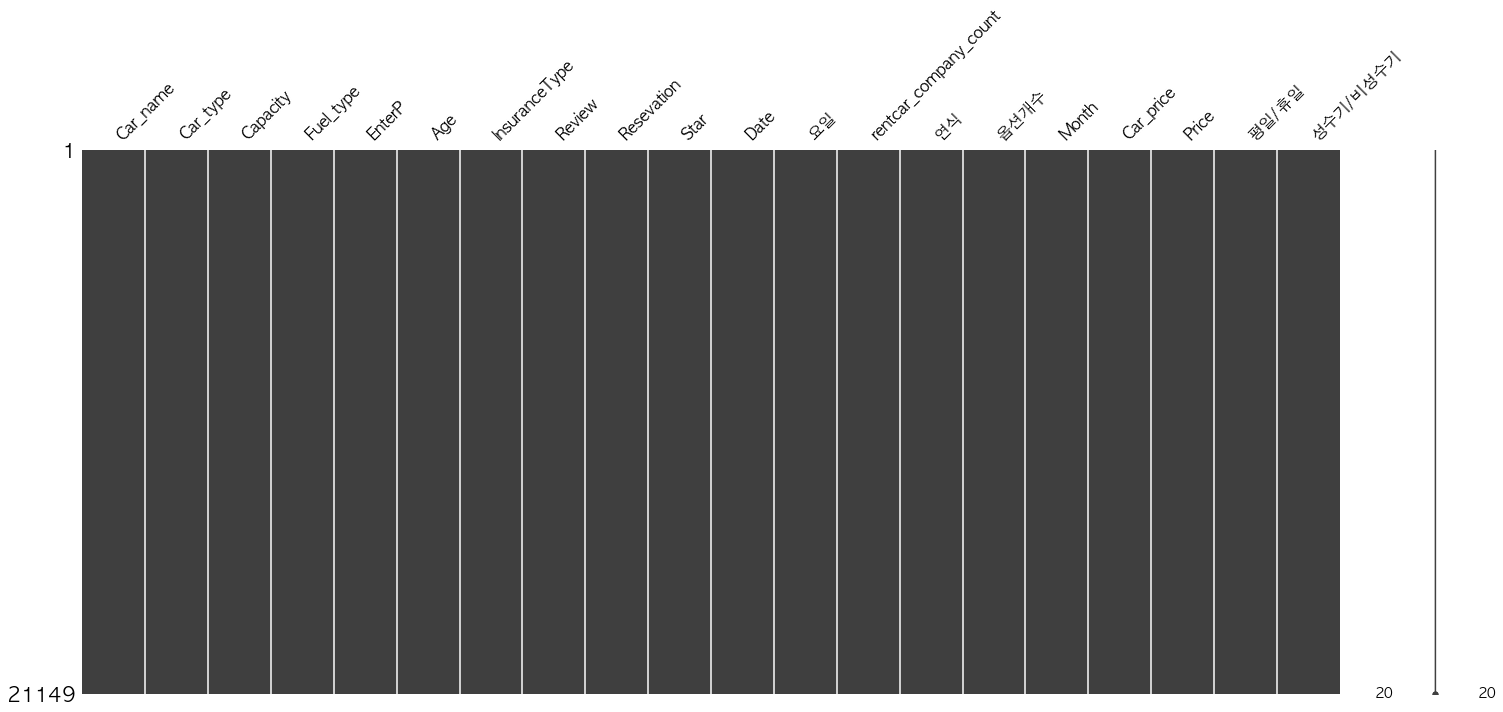

In [6]:
# 데이터셋 결측치 확인
import missingno as msno
msno.matrix(jejurent_df)
plt.show()

---

## 4. 데이터 탐색 (EDA)

### EDA에 앞서 가설을 세워보자.
* 가설1. 차량모델의 가격이 비쌀수록 렌트가격이 높을 것이다.
* 가설2. 성수기에는 평시에 비해 렌트가격이 더 비쌀 것이다.
* 가설3. 평일보다 휴일에 가격이 더 비쌀 것이다.
* 가설4. 부가옵션이 많이 붙은 차량일수록 가격이 비쌀 것이다.
* 가설5. 렌트가능나이가 낮을수록 렌트가격이 저렴할 것이다.
* 가설6. 연식이 오래된 모델일수록 렌트가격이 저렴할 것이다.
* 가설7. 취급업체가 많은 모델일수록 상대적으로 렌트가격이 저렴할 것이다.

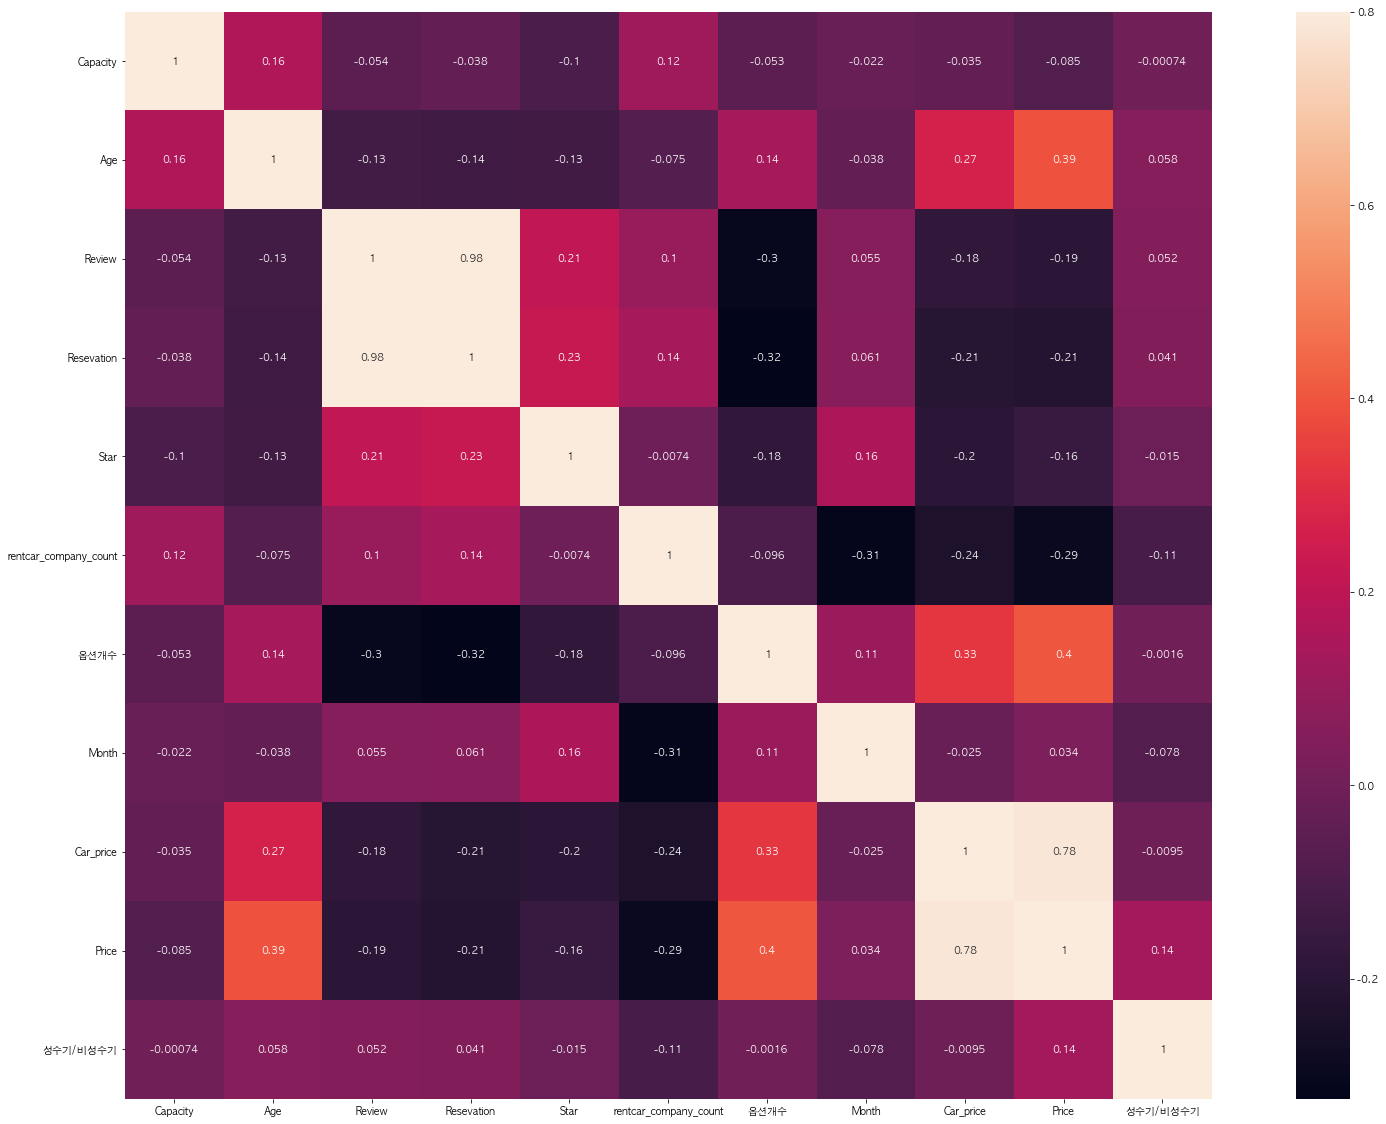

In [7]:
# 히트맵

corrmat = jejurent_df.corr() 
f, ax = plt.subplots(figsize=(30, 20)) 
sns.heatmap(corrmat, vmax=.8, square=True,annot=True);

#### 히트맵



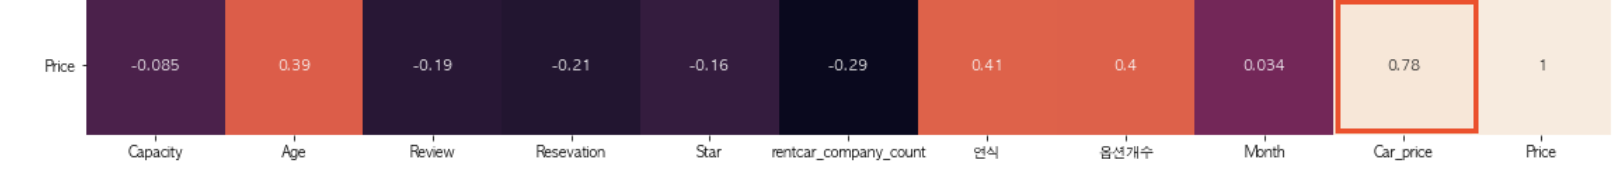

- 렌트가격과 상관관계가 가장 높은 요소는 차의 가격이었다.
- '-'상관관계가 가장 높은 것은 취급업체수. 취급업체수가 많아질수록 가격경쟁력을 위해 렌트가를 인하한다.

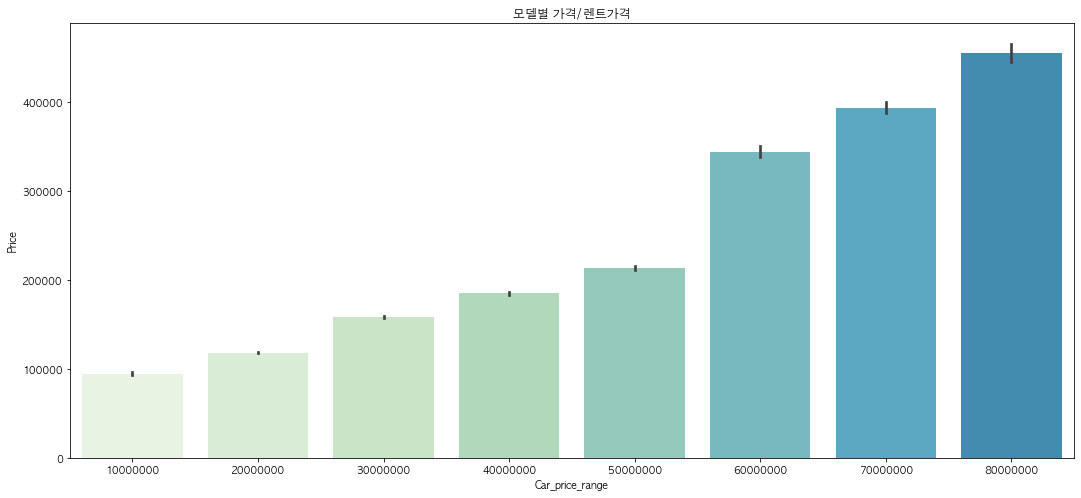

In [8]:
# 차량 가격대별 렌트가격
create_range_data(jejurent_df,'Car_price',0,85000000,10000000)

plt.figure(figsize=(18,8))
sns.barplot(x='Car_price_range',y='Price',data=jejurent_df,palette=sequential)
plt.title('모델별 가격/렌트가격')
plt.show()

drop_col(jejurent_df,'Car_price')

In [9]:
# 차의 가격과 렌트 가격은 정비례한다.

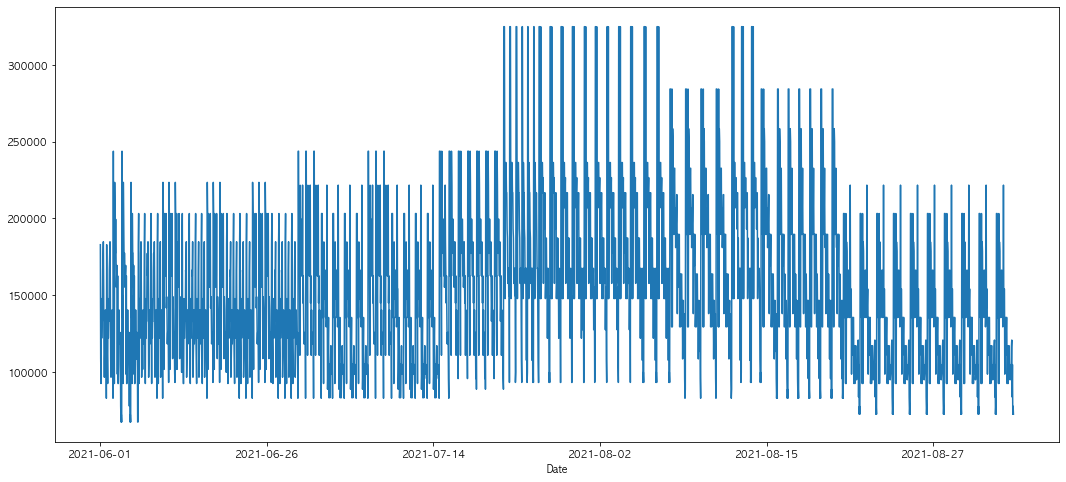

In [10]:
# 성수기 7/8월 성수기에는 렌트가격이 높게 형성된다.

first = jejurent_df[jejurent_df['EnterP'] == '특별한렌트카']

sonata = first[(first["Car_name"] == "K5")]
sonata['Date'] = pd.to_datetime(first['Date'])
first.index = first["Date"]
first.set_index('Date', inplace=True)

plt.figure(figsize=(18,8))
first["Price"].plot()
plt.grid
plt.show()

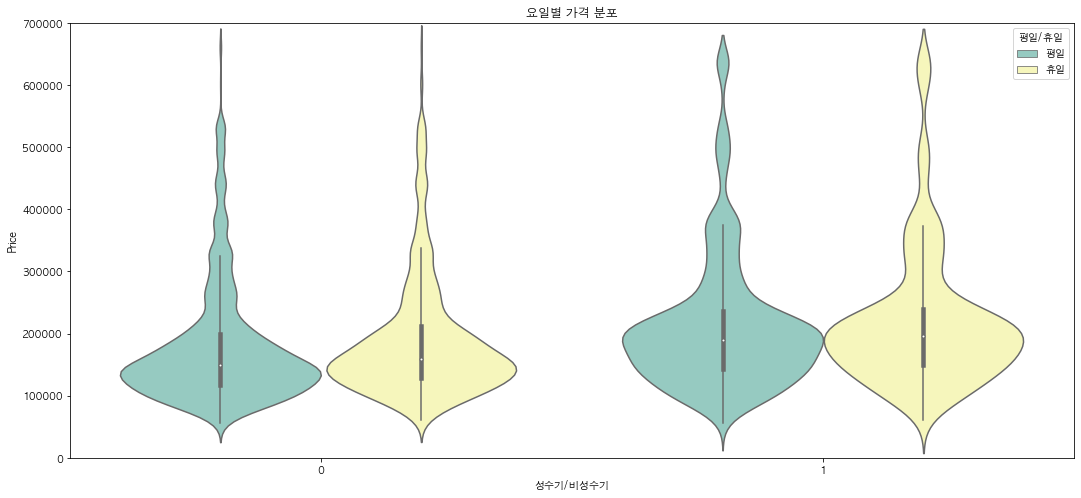

In [11]:
# 성수기 비성수기 가격 비교
# 성수기에는 비성수기보다 가격이 높게 형성된다.
# 평일과 휴일에 가격 차이는 크지 않지만, 휴일이 약간 더 비쌈.
plt.figure(figsize=(18,8))
sns.violinplot(x='성수기/비성수기',y='Price',data=jejurent_df,hue='평일/휴일',palette=categorical)
plt.title('성수기/비성수기 가격 분포')
plt.ylim(0,700000)
plt.show()

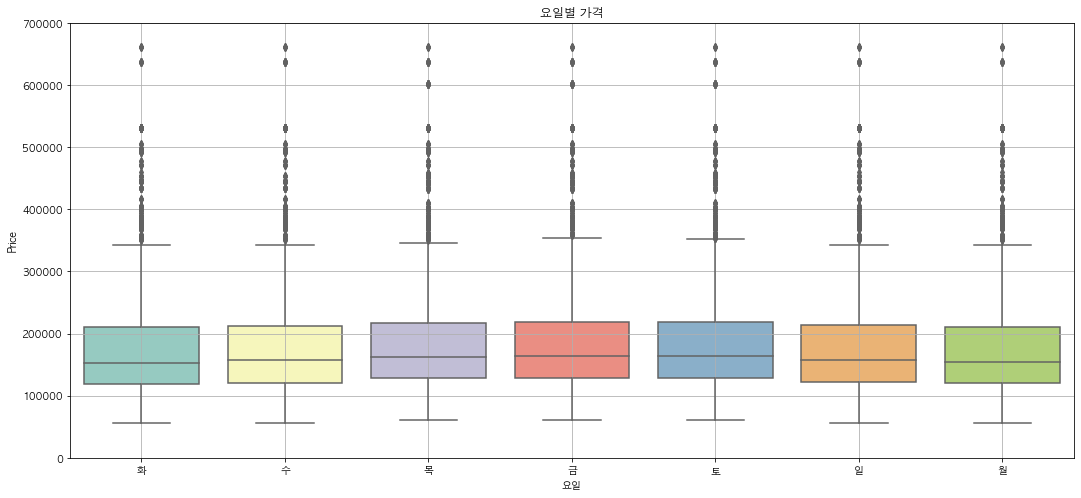

In [12]:
# 요일별 가격 -  요일별로 가격에 큰 차이는 보이지 않는다.
plt.figure(figsize=(18,8))
sns.boxplot(x='요일',y='Price',data=jejurent_df,palette=categorical)
plt.title('요일별 가격')
plt.ylim(0,700000)
plt.grid()
plt.show()

In [13]:
# 차종별 가격 분포

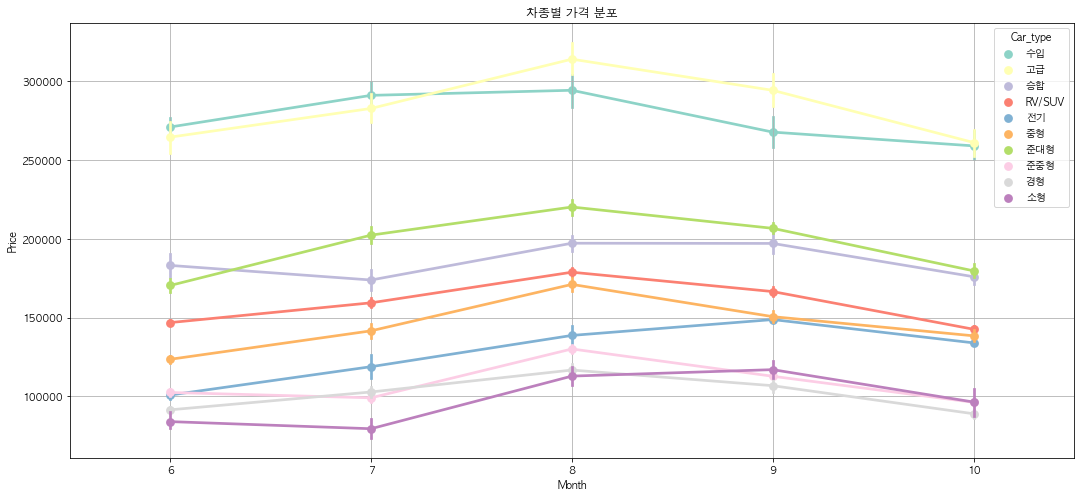

In [14]:
plt.figure(figsize=(18,8))
sns.pointplot(x='Month',y='Price',hue='Car_type', data=jejurent_df,palette=categorical)
plt.title("차종별 가격 분포")
plt.grid()
plt.show()

In [15]:
# 고급차와 수입차가 다른 차종에 비해 렌트가격이 전반적으로 높게 형성되어있음.
# 가장 성수기인 8월에는 가격이 오르는 모습을 보임

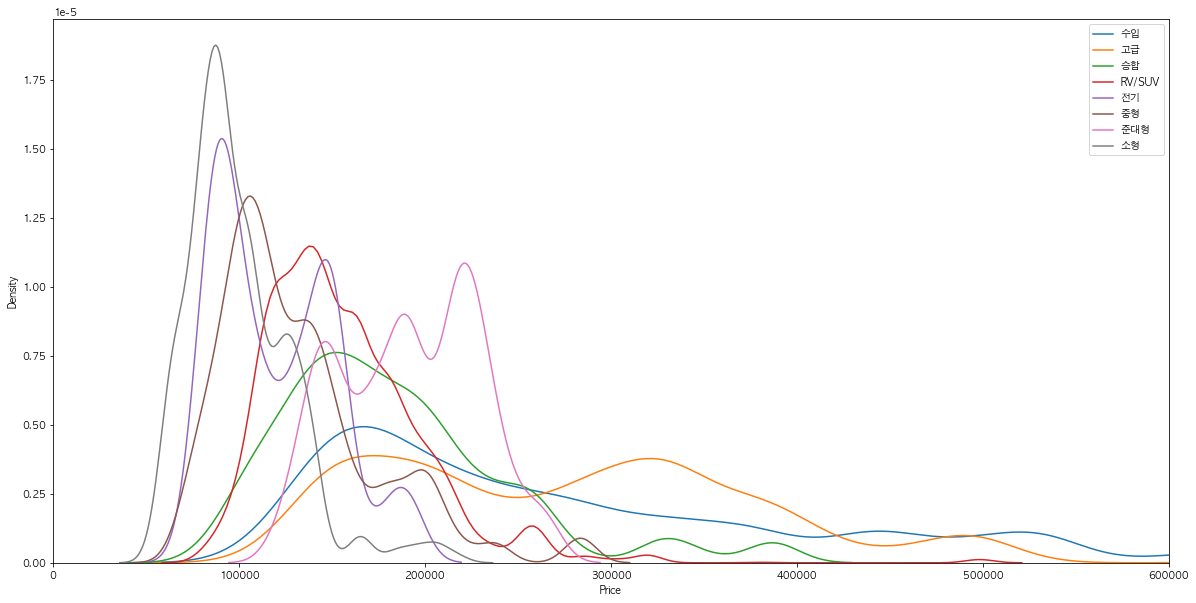

In [16]:
jejurent_df_type = jejurent_df.copy()
jejurent_df_type.loc[jejurent_df_type["Car_type"] == '경형', 'Car_type'] = "소형"
jejurent_df_type.loc[jejurent_df_type["Car_type"] == '준중형', 'Car_type'] = "중형"

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

tp = []
plt.figure(figsize=(20,10))
for ct in jejurent_df_type['Car_type'].unique():
    df = jejurent_df_type[jejurent_df_type['Car_type'] == ct]
    sns.distplot(df['Price'],bins=100,hist=False ,kde=True)
    tp.append(ct)
    plt.xlim(0,600000)
plt.legend(tp)
plt.show()

In [17]:
# 소형,중형,전기차는 대부분 20만원대 이내에 분포
# 승합차, 고급차, 수입차는 10-60만원대 이상까지 넓게 분포 

In [18]:
# 옵션갯수와 렌트 가격의 상관관계
jeju_model = jejurent_df.groupby('Car_name').mean()
jeju_model.sort_values(['옵션개수'],ascending=False).head(5)

Capacity   Age  Review  Resevation  Star  \
Car_name                                                   
벤츠 E220D (경)         5.0  26.0     0.0    8.000000   0.0   
제네시스 EQ900(휘)        5.0  26.0     1.0   44.000000   5.0   
BMW 530D(경)          5.0  26.0     0.0    7.000000   0.0   
볼보 S90 (휘)           5.0  26.0     0.0    5.789474   0.0   
아우디 A5 스포트백(휘)       5.0  26.0     0.0    7.000000   0.0   

                rentcar_company_count  옵션개수     Month   Car_price  \
Car_name                                                            
벤츠 E220D (경)                 1.000000  14.0  6.681159  69200000.0   
제네시스 EQ900(휘)                1.000000  14.0  6.000000  73630000.0   
BMW 530D(경)                  1.000000  13.0  6.681159  85000000.0   
볼보 S90 (휘)                   1.453947  13.0  7.993421  59490000.0   
아우디 A5 스포트백(휘)               1.000000  13.0  6.681159  57010000.0   

                        Price  성수기/비성수기  
Car_name                                 
벤츠 E220D (경)    337613.043478  0.362319  
제네시스 EQ900(휘)   426600.000000  0.000000  
BMW 530D(경)     329791.304348  0.362319  
볼보 S90 (휘)      447498.026316  0.230263  
아우디 A5 스포트백(휘)  293813.043478  0.362319

#### 부가옵션의 갯수와 가격의 상관관계

1. 부가옵션갯수가 많은 차는 고급차 또는 수입차

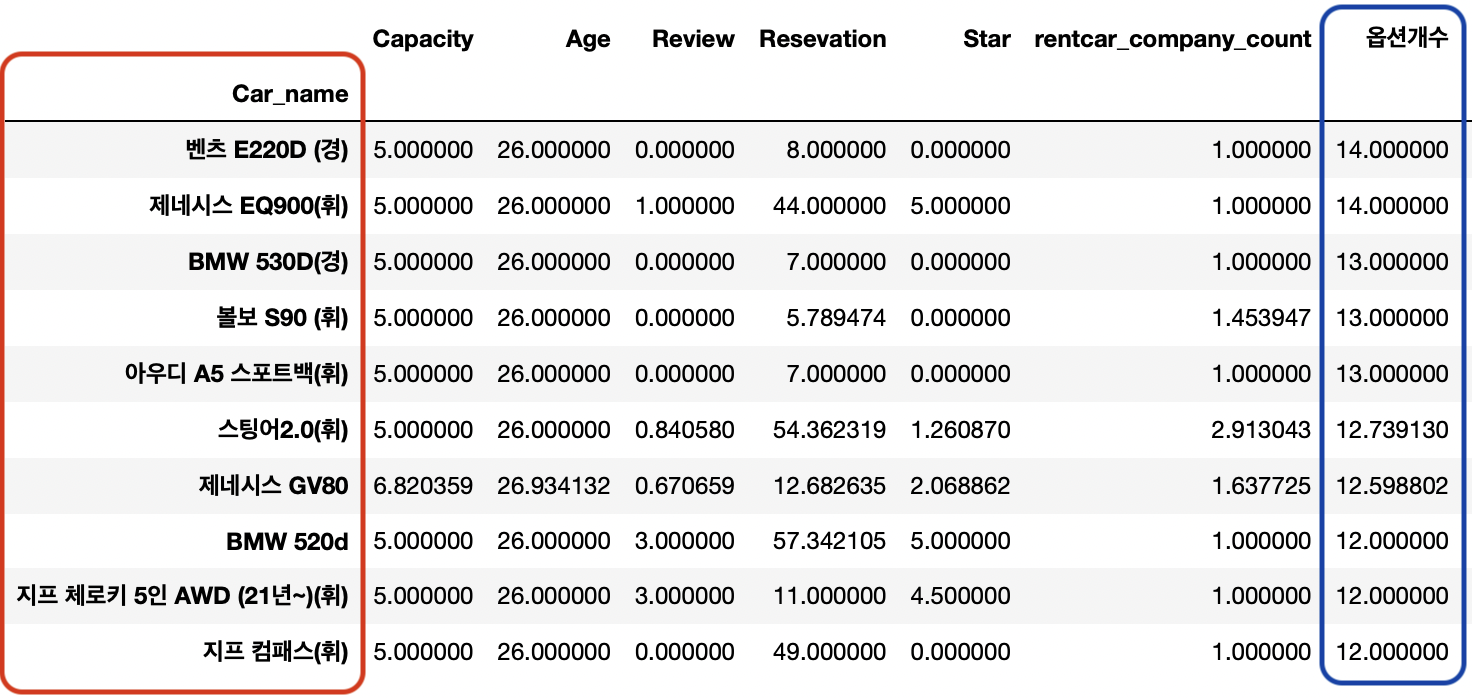


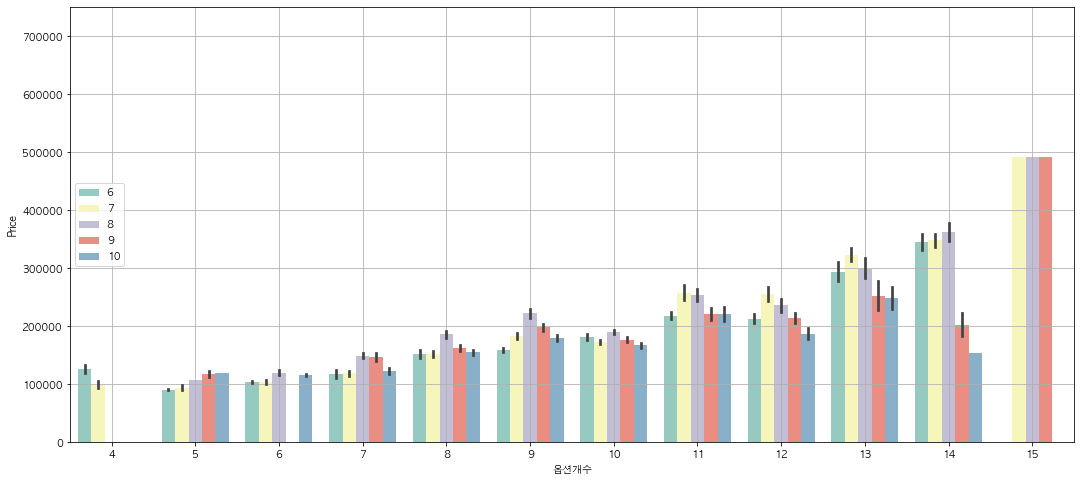

In [19]:
# 옵션갯수와 가격  boxplot

plt.figure(figsize=(18,8))
sns.barplot(x='옵션개수',y='Price',data=jejurent_df,hue='Month',palette=categorical)
plt.legend(loc='center left')
plt.ylim(0,750000)
plt.grid()
plt.show()

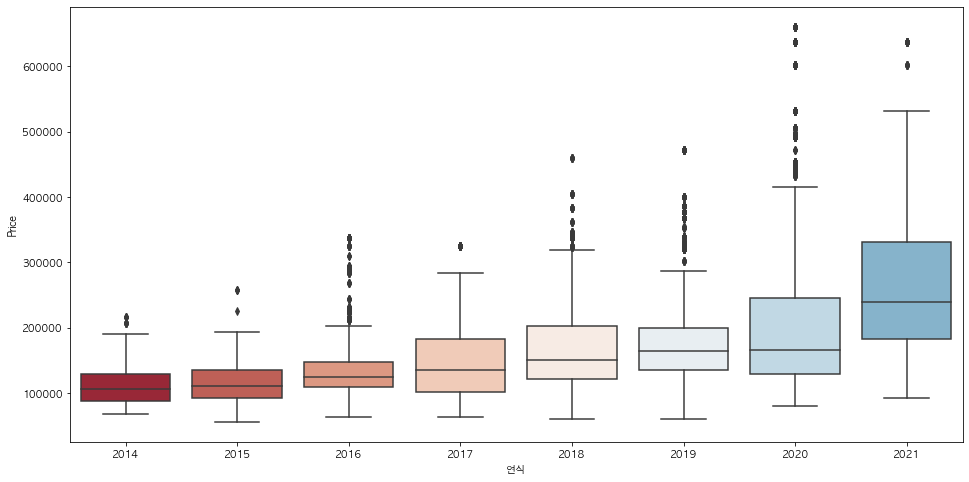

In [20]:
# 연식은 오래된 모델일수록 렌트가격이 저렴하다.
jejurent_df['연식']=jejurent_df['연식'].astype('int')

plt.figure(figsize=(16,8))
sns.boxplot(x='연식',y='Price', data=jejurent_df,palette=sbys)
plt.show()

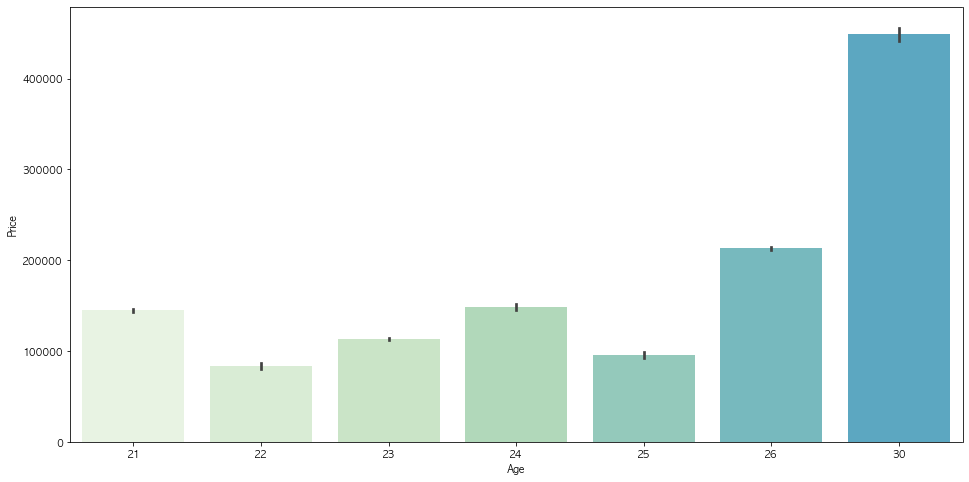

In [21]:
# 렌트가능 나이(Age)와 가격
plt.figure(figsize=(16,8))
sns.barplot(x='Age',y='Price', data=jejurent_df, palette=sequential)
plt.show()

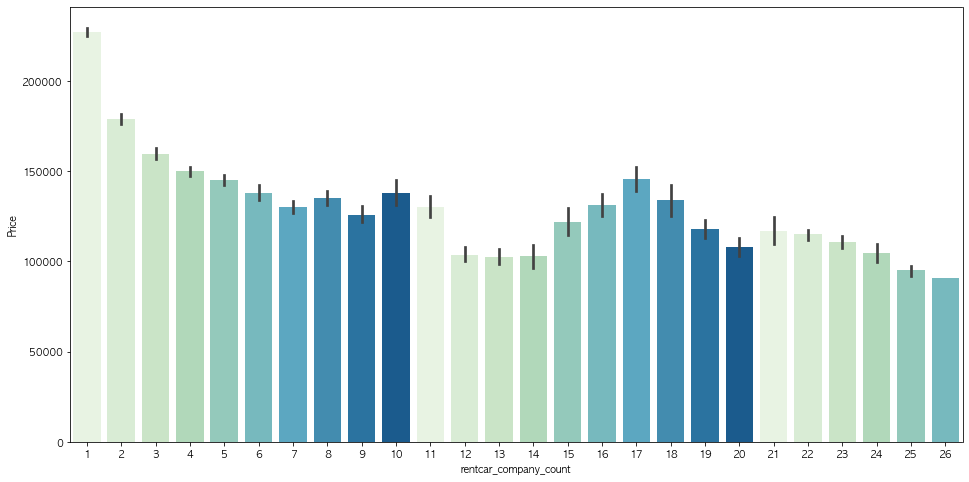

In [22]:
# 취급업체수가 많은 차량모델은 가격이 낮게 형성된다.
plt.figure(figsize=(16,8))
sns.barplot(x='rentcar_company_count',y='Price' \
            ,data=jejurent_df,palette=sequential)
plt.show()

### 데이터 탐색 요약
렌트가격의 형성에 아래 6가지 feature와 상관관계를 확인
- 차량 모델의 가격
- 성수기/비수기
- 차량의 모델 연식
- 차종
- 차량에 포함된 옵션갯수
- 차량의 취급업체 수

---

##  5.  가격예측 모델링

### 베이스라인 설정
EDA를 통해 확인한 주요 수치형 컬럼들만으로 모델링하여 베이스라인을 확인

- 차량 모델의 가격
- 성수기/비수기
- 차량의 모델 연식
- 차량에 포함된 옵션갯수
- 차량의 취급업체 수

In [23]:
# 데이터셋 만들기
jeju_df_bs = jejurent_df.copy()

base_dataset = jeju_df_bs[['Car_price','성수기/비성수기','연식','옵션개수','rentcar_company_count','Price']]

from sklearn.model_selection import train_test_split

x = base_dataset.drop(['Price'],axis=1)
y = base_dataset['Price'].astype(float)

x_train, x_test, y_train, y_test = train_test_split(x, y,\
                                                    test_size=0.2, random_state=13)

In [24]:
# OLS
lm = sm.OLS(y_train, x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          4.148e+04
Date:                Wed, 18 May 2022   Prob (F-statistic):                        0.00
Time:                        13:12:54   Log-Likelihood:                     -2.0992e+05
No. Observations:               16919   AIC:                                  4.198e+05
Df Residuals:                   16914   BIC:                                  4.199e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Car_price                 0.0046   3.12e-05    147.020      0.000       0.005       0.005
성수기/비성수기               3.291e+04   1114.332     29.532      0.000    3.07e+04    3.51e+04
연식                      -19.4835      1.259    -15.480      0.000     -21.951     -17.017
옵션개수                   8755.4720    260.901     33.559      0.000    8244.078    9266.866
rentcar_company_count -2904.7523    138.692    -20.944      0.000   -3176.604   -2632.901
==============================================================================
Omnibus:                     2962.718   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11074.292
Skew:                           0.848   Prob(JB):                         0.00
Kurtosis:                       6.582   Cond. No.                     8.69e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.69e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# 리니어리그레션 RMSE - test데이터의 rmse가 약 55500

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


lr = LinearRegression()
lr.fit(x_train,y_train)

pred_tr = lr.predict(x_train)
pred_test = lr.predict(x_test)
rmse_tr = np.sqrt(mean_squared_error(y_train,pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))

print('RMSE of train :',rmse_tr)
print('RMSE of test :',rmse_test)

RMSE of train : 56562.88375021817
RMSE of test : 55530.531504669016


In [26]:
# 랜덤포레스트 리그레서 RMSE

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rr = RandomForestRegressor()
rr.fit(x_train,y_train)

predrr_tr = rr.predict(x_train) 
predrr_test = rr.predict(x_test)
mserr_tr = mean_squared_error(y_train,predrr_tr)
mserr_test = mean_squared_error(y_test,predrr_test)
rmserr_tr = np.sqrt(mean_squared_error(y_train,predrr_tr))
rmserr_test = np.sqrt(mean_squared_error(y_test,predrr_test))


# test데이터 예측치의 RMSE값이 약 17000원정도의 오차
print('MSE of train :',mserr_tr)
print('MSE of test :',mserr_test)
print('RMSE of train :',rmserr_tr)
print('RMSE of test :',rmserr_test)

MSE of train : 249469160.71877518
MSE of test : 279672602.3118724
RMSE of train : 15794.592768374092
RMSE of test : 16723.41479219697


#### 랜덤포레스트로 학습한 모델의 예측값의 RMSE값: 약 16000원 정도의 오차를 보임
- RMSE of Test: 16000을 베이스라인으로 설정하자!

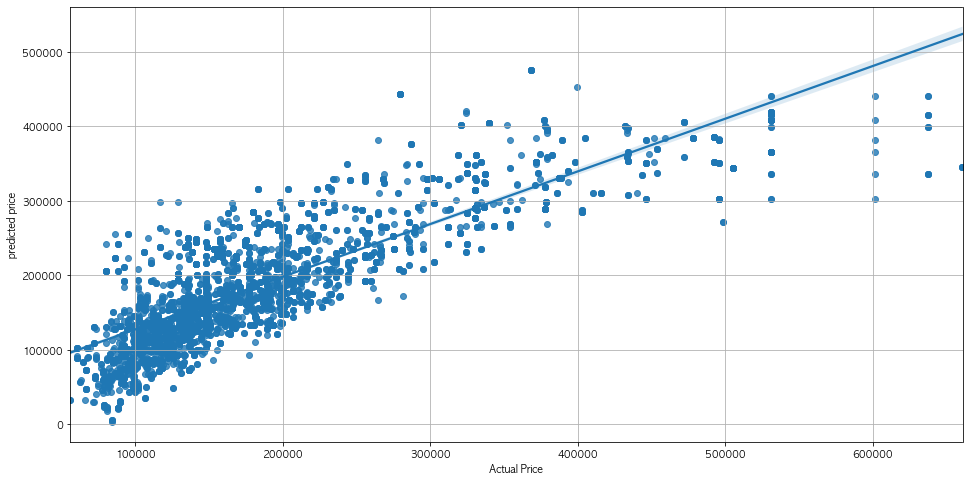

In [27]:
# test데이터의 실제값과 예측값 scatterplot
plt.figure(figsize=(16,8))
sns.regplot(y_test,pred_test,fit_reg=True)
plt.xlabel('Actual Price')
plt.ylabel('predicted price')
plt.grid()
plt.show();

---

## 전체 데이터셋 활용


####  그전에!  우선  카테고리 데이터들을 수치형데이터로 처리해야!

### 모델의 가격예측성능을 높이기 위해 다음과 같은 방법으로 수치형데이터 전처리를 시도해보았다.
- 첫번째 시도1. 모든 범주형 데이터 더미변수화
- 두번째 시도2. 일부 컬럼 라벨 인코딩 + 범주형 데이터 더미변수화 
- 세번째 시도3. 일부 컬럼 카테고리임베딩 + 더미변수화

### 첫번째 시도1 : 모든 범주형 데이터 더미변수화 


##### dataframe
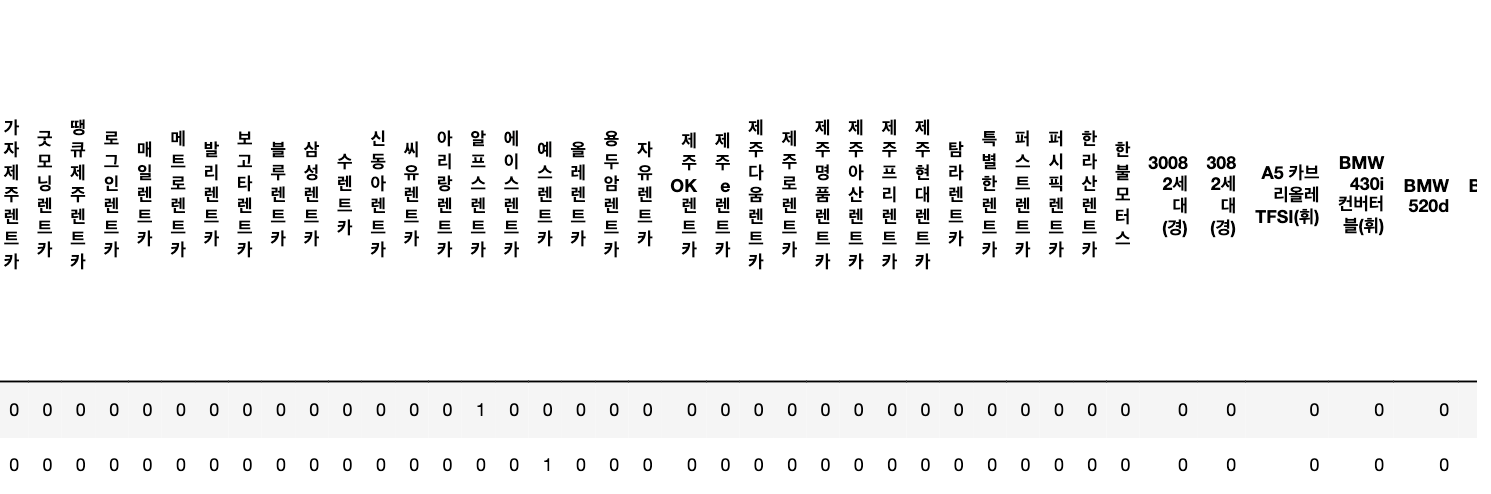
##### 컬럼이 180개..
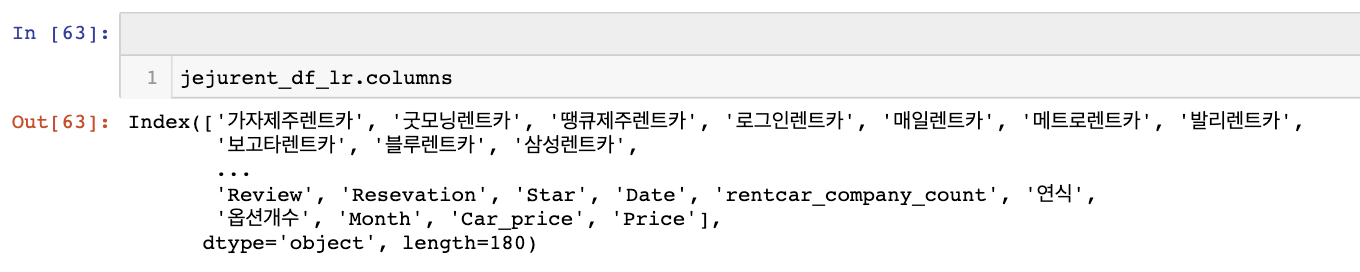

In [27]:
# 더미변수화

jejurent_df_lr = jejurent_df.copy()

categorical_cols = ['Car_type','요일','Fuel_type','InsuranceType', '평일/휴일','성수기/비성수기','Car_name', "EnterP"]

for categorical_col in categorical_cols:
    jejurent_df_lr = pd.concat([pd.get_dummies(jejurent_df_lr[categorical_col]) 
                                  ,jejurent_df_lr.drop(columns=categorical_col)], axis=1)
    
# 일자 삭제
jejurent_df_lr
jejurent_df_lr.drop(columns=["Date"], inplace=True)

# 데이터 나누기
from sklearn.model_selection import train_test_split


x = jejurent_df_lr.drop(['Price'], axis=1)
y = jejurent_df_lr['Price'].astype(float)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

In [28]:
jejurent_df_lr

가자제주렌트카  굿모닝렌트카  땡큐제주렌트카  로그인렌트카  매일렌트카  메트로렌트카  발리렌트카  보고타렌트카  블루렌트카  \
0            0       0        0       0      0       0      0       0      0   
1            0       0        0       0      0       0      0       0      0   
2            0       0        0       0      0       0      0       0      0   
3            0       0        0       0      0       0      0       0      0   
4            0       0        0       0      0       0      0       0      0   
...        ...     ...      ...     ...    ...     ...    ...     ...    ...   
21144        0       0        0       0      0       0      0       0      0   
21145        0       0        0       0      0       0      0       0      0   
21146        0       0        0       0      0       0      0       0      0   
21147        0       0        0       0      0       0      0       0      0   
21148        0       0        0       0      0       0      0       0      0   

       삼성렌트카  수렌트카  신동아렌트카  씨유렌트카  아리랑렌트카  알프스렌트카  에이스렌트카  예스렌트카  올레렌트카  \
0          0     0       0      0       0       1       0      0      0   
1          0     0       0      0       0       0       0      1      0   
2          0     0       0      0       0       0       0      0      0   
3          0     0       0      0       0       0       0      0      0   
4          0     0       0      0       0       0       0      0      0   
...      ...   ...     ...    ...     ...     ...     ...    ...    ...   
21144      0     0       0      0       0       0       0      0      0   
21145      0     0       0      0       0       0       0      0      0   
21146      0     0       0      0       0       0       0      0      0   
21147      0     0       0      0       0       0       0      0      0   
21148      0     0       0      0       0       0       0      0      0   

       용두암렌트카  자유렌트카  제주OK렌트카  제주e렌트카  제주다움렌트카  제주로렌트카  제주명품렌트카  제주아산렌트카  \
0           0      0        0       0        0       0        0        0   
1           0      0        0       0        0       0        0        0   
2           0      0        1       0        0       0        0        0   
3           0      0        0       0        1       0        0        0   
4           0      0        0       0        0       0        0        0   
...       ...    ...      ...     ...      ...     ...      ...      ...   
21144       0      0        0       0        0       0        0        0   
21145       0      0        0       0        0       0        0        0   
21146       0      0        0       0        0       0        0        0   
21147       0      0        0       0        0       0        0        0   
21148       0      0        0       0        0       0        0        0   

       제주프리렌트카  제주현대렌트카  탐라렌트카  특별한렌트카  퍼스트렌트카  퍼시픽렌트카  한라산렌트카  한불모터스  \
0            0        0      0       0       0       0       0      0   
1            0        0      0       0       0       0       0      0   
2            0        0      0       0       0       0       0      0   
3            0        0      0       0       0       0       0      0   
4            0        0      0       0       0       1       0      0   
...        ...      ...    ...     ...     ...     ...     ...    ...   
21144        0        0      0       0       1       0       0      0   
21145        0        0      0       0       1       0       0      0   
21146        0        0      0       0       1       0       0      0   
21147        0        0      0       0       1       0       0      0   
21148        0        0      0       0       1       0       0      0   

       3008 2세대(경)  308 2세대(경)  A5 카브리올레 TFSI(휘)  BMW 430i 컨버터블(휘)  BMW 520d  \
0                0           0                 0                 0         0   
1                0           0                 0                 0         0   
2                0           0                 0                 0         0   
3                0           0     

In [29]:
# statsmodel OLS summary 
# R-squard 수치가 0.933으로 매우 양호
# 컨디션넘버가 높은 것이 신경 쓰임. -> 컬럼의 갯수가 너무 많아서 생긴 문제일까?

lm = sm.OLS(y_train, x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1478.
Date:                Tue, 17 May 2022   Prob (F-statistic):               0.00
Time:                        15:43:42   Log-Likelihood:            -1.9638e+05
No. Observations:               16919   AIC:                         3.931e+05
Df Residuals:                   16761   BIC:                         3.943e+05
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
가자제주렌트카                  -1.365e+05   6983.364    -19.550      0.000    -1.5e+05   -1.23e+05
굿모닝렌트카                    -7.93e+04   9291.317     -8.535      0.000   -9.75e+04   -6.11e+04
땡큐제주렌트카                  -1.149e+05   6709.548    -17.129      0.000   -1.28e+05   -1.02e+05
로그인렌트카                   -8.356e+04   6894.518    -12.120      0.000   -9.71e+04      -7e+04
매일렌트카                    -1.356e+05   6432.767    -21.072      0.000   -1.48e+05   -1.23e+05
메트로렌트카                   -1.442e+05   9063.175    -15.907      0.000   -1.62e+05   -1.26e+05
발리렌트카                    -1.101e+05   7298.622    -15.089      0.000   -1.24e+05   -9.58e+04
보고타렌트카                   -1.311e+05   7737.999    -16.945      0.000   -1.46e+05   -1.16e+05
블루렌트카                    -1.923e+05   1.35e+04    -14.296      0.000   -2.19e+05   -1.66e+05
삼성렌트카                    -1.266e+05   6987.057    -18.116      0.000    -1.4e+05   -1.13e+05
수렌트카                     -1.131e+05   7003.091    -16.145      0.000   -1.27e+05   -9.93e+04
신동아렌트카                   -8.506e+04   7165.995    -11.870      0.000   -9.91e+04    -7.1e+04
씨유렌트카                    -1.256e+05   6816.939    -18.421      0.000   -1.39e+05   -1.12e+05
아리랑렌트카                    2.804e+04   9296.033      3.016      0.003    9817.354    4.63e+04
알프스렌트카                   -1.132e+05   6685.269    -16.932      0.000   -1.26e+05      -1e+05
에이스렌트카                   -1.268e+05   6831.922    -18.559      0.000    -1.4e+05   -1.13e+05
예스렌트카                    -4.755e+04   7194.361     -6.609      0.000   -6.17e+04   -3.34e+04
올레렌트카                    -1.212e+05   7322.394    -16.556      0.000   -1.36e+05   -1.07e+05
용두암렌트카                   -1.117e+05   6857.228    -16.294      0.000   -1.25e+05   -9.83e+04
자유렌트카                    -7.295e+04   6739.304    -10.825      0.000   -8.62e+04   -5.97e+04
제주OK렌트카                  -1.501e+05   6913.634    -21.705      0.000   -1.64e+05   -1.37e+05
제주e렌트카                   -1.151e+05   6529.699    -17.635      0.000   -1.28e+05   -1.02e+05
제주다움렌트카                  -1.433e+05   6978.591    -20.528      0.000   -1.57e+05    -1.3e+05
제주로렌트카                   -1.595e+05   6542.157    -24.385      0.000   -1.72e+05   -1.47e+05
제주명품렌트카                  -1.472e+05   1.02e+04    -14.415      0.000   -1.67e+05   -1.27e+05
제주아산렌트카                   -9.41e+04   7043.434    -13.359      0.000   -1.08e+05   -8.03e+04
제주프리렌트카                  -1.164e+05   1.03e+04    -11.308      0.000   -1.37e+05   -9.62e+04
제주현대렌트카                  -1.714e+05   7031.628    -24.383      0.000   -1.85e+05   -1.58e+05
탐라렌트카                    -1.274e+05   6771.434    -18.815      0.000   -1.41e+05   -1.14e+05
특별한렌트카                   -1.306e+05   6697.836    -19.499      0.000   -1.44e+05   -1.17e+05
퍼스트렌트카        

In [ ]:
# 리니어리그레션 RMSE - test데이터의 rmse가 약 26700

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


lr = LinearRegression()
lr.fit(x_train,y_train)

pred_tr = lr.predict(x_train)
pred_test = lr.predict(x_test)
rmse_tr = np.sqrt(mean_squared_error(y_train,pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))

print('RMSE of train :',rmse_tr)
print('RMSE of test :',rmse_test)

In [30]:
# 랜덤포레스트 리그레서 RMSE

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rr = RandomForestRegressor()
rr.fit(x_train,y_train)

predrr_tr = rr.predict(x_train) 
predrr_test = rr.predict(x_test)
mserr_tr = mean_squared_error(y_train,predrr_tr)
mserr_test = mean_squared_error(y_test,predrr_test)
rmserr_tr = np.sqrt(mean_squared_error(y_train,predrr_tr))
rmserr_test = np.sqrt(mean_squared_error(y_test,predrr_test))


print('MSE of train :',mserr_tr)
print('MSE of test :',mserr_test)
print('RMSE of train :',rmserr_tr)
print('RMSE of test :',rmserr_test)

MSE of train : 54448122.58960816
MSE of test : 136142736.78561038
RMSE of train : 7378.8971120085525
RMSE of test : 11668.021973994151


In [ ]:
# test데이터의 rmse값이 10000원초반대로 매우 낮아짐

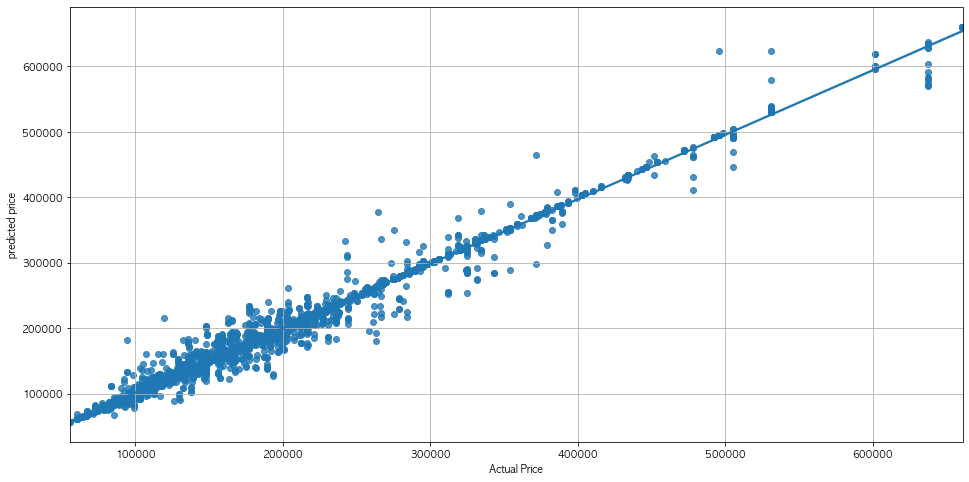

In [32]:
# test데이터의 실제값과 예측값 scatterplot
plt.figure(figsize=(16,8))
sns.regplot(y_test,predrr_test,fit_reg=True)
plt.xlabel('Actual Price')
plt.ylabel('predicted price')
plt.grid()
plt.show();

In [57]:
# 이상치 분석
# 회귀선에 멀찍이 떨어져 예측치와 실제값의 차이가 많이나는 컬럼을 추려보자.
outlier_df = pd.DataFrame({"pred":predrr_test, "y_test":y_test, '모델명':jejurent_df["Car_name"].loc[y_test.index], 
                         '차종':jejurent_df['Car_type'].loc[y_test.index],"렌트카 업체":jejurent_df["EnterP"].loc[y_test.index] ,"값 차이":abs(predrr_test-y_test),"날짜":jejurent_df["Date"].loc[y_test.index]})
outlier_df[outlier_df['값 차이']>=90000]

pred  y_test               모델명  차종  렌트카 업체           값 차이  \
12582  623376.300000  495600        볼보 S90 (휘)  수입  퍼스트렌트카  127776.300000   
6      378194.000000  264400          BMW 520d  수입  퍼스트렌트카  113794.000000   
12575  632598.000000  531000  BMW 430i 컨버터블(휘)  수입  퍼스트렌트카  101598.000000   
15492  217589.005159  119100                K5  중형   매일렌트카   98489.005159   
12820  468838.100000  371700         제네시스 GV80  고급  퍼스트렌트카   97138.100000   

               날짜  
12582  2021-08-16  
6      2021-06-01  
12575  2021-08-16  
15492  2021-09-10  
12820  2021-08-18

In [ ]:
# 대부분 수입차 또는 고급차임을 알 수 있음.

### 두번째 시도 2 : 일부 컬럼 라벨 인코딩 + 범주형 데이터 더미변수화 
- "Car_name", "EnterP" 컬럼의 경우 unique한 값이 너무 많아서 더미변수화했을 때, 컬럼의 갯수가 너무 많아지는 문제가 발생.
- 컬럼갯수가 너무 많아 모델링에 있어 Over Fitting이 우려되었기에, 일부 컬럼의 경우 데이터간 위계의 발생문제를 사전에 감안하고 라벨인코딩을 진행함.

#### 라벨인코딩 컬럼 선정 
- "Car_name", "EnterP"

#### 더미 변수화
- 'Fuel_type','InsuranceType', '평일/휴일','요일', 'Car_type'

In [41]:
# 라벨 인코딩

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()




jejurent_df_lr_label = jejurent_df.copy()
#jejurent_df_lr_label.drop(columns="Car_price", axis=1, inplace=True)

categorical_cols = ['EnterP','Car_name']


for categorical_col in categorical_cols:
    jejurent_df_lr_label[f'{categorical_col}_le'] = le.fit_transform(jejurent_df_lr_label[categorical_col])
    jejurent_df_lr_label = jejurent_df_lr_label.drop(columns=[categorical_col],axis=1)

In [42]:
# 더미변수화

categorical_cols = ['Fuel_type','InsuranceType', '평일/휴일','성수기/비성수기',"요일", 'Car_type']


for categorical_col in categorical_cols:
    jejurent_df_lr_label = pd.concat([pd.get_dummies(jejurent_df_lr_label[categorical_col]) 
                                  ,jejurent_df_lr_label.drop(columns=categorical_col)], axis=1)

In [43]:
# 일자 삭제
jejurent_df_lr_label
jejurent_df_lr_label.drop(columns=["Date"], inplace=True)

In [44]:
# 데이터 나누기
from sklearn.model_selection import train_test_split


x = jejurent_df_lr_label.drop(['Price'], axis=1).astype(float)
y = jejurent_df_lr_label['Price'].astype(float)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

In [45]:
jejurent_df_lr_label

RV/SUV  경형  고급  소형  수입  승합  전기  준대형  준중형  중형  금  목  수  월  일  토  화  0  \
0           0   0   0   0   1   0   0    0    0   0  0  0  0  0  0  0  1  1   
1           0   0   0   0   1   0   0    0    0   0  0  0  0  0  0  0  1  1   
2           0   0   1   0   0   0   0    0    0   0  0  0  0  0  0  0  1  1   
3           0   0   0   0   1   0   0    0    0   0  0  0  0  0  0  0  1  1   
4           0   0   0   0   1   0   0    0    0   0  0  0  0  0  0  0  1  1   
...       ...  ..  ..  ..  ..  ..  ..  ...  ...  .. .. .. .. .. .. .. .. ..   
21144       0   0   0   0   1   0   0    0    0   0  0  0  0  0  0  1  0  1   
21145       0   0   0   0   1   0   0    0    0   0  0  0  0  0  0  1  0  1   
21146       0   0   0   0   1   0   0    0    0   0  0  0  0  0  0  1  0  1   
21147       0   0   0   0   1   0   0    0    0   0  0  0  0  0  0  1  0  1   
21148       0   0   0   0   1   0   0    0    0   0  0  0  0  0  0  1  0  1   

       1  평일  휴일  부분무제한  슈퍼무제한  완전자차  LPG  경유  전기차  하이브리드  휘발유  Capacity  Age  \
0      0   1   0      0      0     1    0   1    0      0    0         5   26   
1      0   1   0      0      0     1    0   1    0      0    0         5   26   
2      0   1   0      1      0     0    0   0    0      0    1         5   26   
3      0   1   0      0      0     1    0   0    0      0    1         4   26   
4      0   1   0      0      1     0    0   0    1      0    0         5   26   
...   ..  ..  ..    ...    ...   ...  ...  ..  ...    ...  ...       ...  ...   
21144  0   0   1      0      0     1    0   0    1      0    0         5   26   
21145  0   0   1      0      0     1    0   0    0      0    1         5   26   
21146  0   0   1      0      0     1    0   0    0      0    1         4   26   
21147  0   0   1      0      0     1    0   0    0      0    1         2   26   
21148  0   0   1      0      0     1    0   0    0      0    1         4   26   

       Review  Resevation  Star  rentcar_company_count    연식  옵션개수  Month  \
0           0           7   0.0                      1  2019    13      6   
1           2          20   3.1                      1  2019     9      6   
2           0           7   0.0                      2  2019    10      6   
3           1          27   5.0                      3  2020     9      6   
4           1          17   4.3                      1  2020    11      6   
...       ...         ...   ...                    ...   ...   ...    ...   
21144       8         233   3.7                      1  2020     9     10   
21145       0           9   0.0                      1  2021    13     10   
21146       3          24   4.8                      1  2020    11     10   
21147       1           5   4.6                      1  2021     9     10   
21148       0           1   0.0                      1  2021    12     10   

       Car_price   Price  EnterP_le  Car_name_le  
0       85000000  279600         14            6  
1       80300000  472000         16           43  
2       79070000  320500         20           78  
3       76500000  378900         22            3  
4       74790000  378000         31           93  
...          ...     ...        ...          ...  
21144   54790000  446100         30           92  
21145   59490000  446100         30           46  
21146   76500000  531000         30            3  
21147   66400000  531000         30            8  
21148   75660000  531000         30            2  

[21149 rows x 42 columns]

In [46]:
# statsmodel OLS summary 
# 컨디션넘버가 낮아졌지만, R-squared값도 하락

lm = sm.OLS(y_train.astype(float), x_train.astype(float)).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     1794.
Date:                Tue, 17 May 2022   Prob (F-statistic):               0.00
Time:                        15:52:37   Log-Likelihood:            -2.0608e+05
No. Observations:               16919   AIC:                         4.122e+05
Df Residuals:                   16883   BIC:                         4.125e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
RV/SUV                -1.226e+06   3.01e+04    -40.688      0.000   -1.29e+06   -1.17e+06
경형                    -1.211e+06   3.01e+04    -40.280      0.000   -1.27e+06   -1.15e+06
고급                    -1.235e+06   3.02e+04    -40.948      0.000   -1.29e+06   -1.18e+06
소형                    -1.201e+06   3.02e+04    -39.747      0.000   -1.26e+06   -1.14e+06
수입                    -1.226e+06   3.06e+04    -40.057      0.000   -1.29e+06   -1.17e+06
승합                    -1.228e+06   3.03e+04    -40.511      0.000   -1.29e+06   -1.17e+06
전기                    -1.291e+06   3.03e+04    -42.683      0.000   -1.35e+06   -1.23e+06
준대형                   -1.227e+06   3.02e+04    -40.658      0.000   -1.29e+06   -1.17e+06
준중형                   -1.214e+06      3e+04    -40.490      0.000   -1.27e+06   -1.16e+06
중형                    -1.231e+06   3.03e+04    -40.675      0.000   -1.29e+06   -1.17e+06
금                     -1.767e+06   4.31e+04    -40.993      0.000   -1.85e+06   -1.68e+06
목                     -1.744e+06   4.31e+04    -40.472      0.000   -1.83e+06   -1.66e+06
수                     -1.752e+06   4.31e+04    -40.644      0.000   -1.84e+06   -1.67e+06
월                     -1.754e+06   4.31e+04    -40.697      0.000   -1.84e+06   -1.67e+06
일                     -1.752e+06   4.31e+04    -40.638      0.000   -1.84e+06   -1.67e+06
토                     -1.768e+06   4.31e+04    -41.025      0.000   -1.85e+06   -1.68e+06
화                     -1.754e+06   4.31e+04    -40.693      0.000   -1.84e+06   -1.67e+06
0                     -6.162e+06   1.51e+05    -40.869      0.000   -6.46e+06   -5.87e+06
1                     -6.129e+06   1.51e+05    -40.649      0.000   -6.42e+06   -5.83e+06
평일                    -6.158e+06   1.51e+05    -40.842      0.000   -6.45e+06   -5.86e+06
휴일                    -6.134e+06   1.51e+05    -40.673      0.000   -6.43e+06   -5.84e+06
부분무제한                 -4.112e+06      1e+05    -40.988      0.000   -4.31e+06   -3.92e+06
슈퍼무제한                 -4.078e+06   1.01e+05    -40.479      0.000   -4.28e+06   -3.88e+06
완전자차                  -4.102e+06   1.01e+05    -40.803      0.000    -4.3e+06    -3.9e+06
LPG                   -2.442e+06   6.03e+04    -40.498      0.000   -2.56e+06   -2.32e+06
경유                     -2.46e+06   6.03e+04    -40.818      0.000   -2.58e+06   -2.34e+06
전기차                   -2.506e+06   6.06e+04    -41.372      0.000   -2.62e+06   -2.39e+06
하이브리드                  -2.44e+06   6.01e+04    -40.593      0.000   -2.56e+06   -2.32e+06
휘발유                   -2.443e+06   6.05e+04    -40.411      0.000   -2.56e+06   -2.32e+06
Capacity               -604.5732    478.430     -1.264      0.206   -1542.345     333.199
Age                    1.148e+04    245.836     46.686      0.000     1.1e+04     1.2e+04
Review                 

In [47]:
# 리니어리그레션 RMSE 
# 단순히 더미변수화했을 때보다 RMSE값이 크게 떨어졌다.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


lr = LinearRegression()
lr.fit(x_train,y_train)

pred_tr = lr.predict(x_train)
pred_test = lr.predict(x_test)
rmse_tr = np.sqrt(mean_squared_error(y_train,pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))

print('RMSE of train :',rmse_tr)
print('RMSE of test :',rmse_test)

RMSE of train : 47168.9639096087
RMSE of test : 45884.44564406614


In [48]:
# 랜덤포레스트 리그레서 RMSE

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



rr = RandomForestRegressor()
rr.fit(x_train,y_train)

predrr_tr = rr.predict(x_train) 
predrr_test = rr.predict(x_test)
mserr_tr = mean_squared_error(y_train,predrr_tr)
mserr_test = mean_squared_error(y_test,predrr_test)
rmserr_tr = np.sqrt(mean_squared_error(y_train,predrr_tr))
rmserr_test = np.sqrt(mean_squared_error(y_test,predrr_test))

print('MSE of train :',mserr_tr)
print('MSE of test :',mserr_test)
print('RMSE of train :',rmserr_tr)
print('RMSE of test :',rmserr_test)

MSE of train : 54550715.81946417
MSE of test : 134238512.3456735
RMSE of train : 7385.845640105415
RMSE of test : 11586.134486776575


### K-Fold로 교차검증

In [49]:
# K-Fold= 5
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

kfold =KFold(n_splits=5)
rf_cv = RandomForestRegressor()

# k-fold=5로 cross validation의 rmse값의 평균값 출력
cv_rmse = []
for train_idx, test_idx in kfold.split(x):
    x_train_cv, x_test_cv = x.iloc[train_idx], x.iloc[test_idx] 
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    rf_cv.fit(x_train_cv,y_train_cv)
    pred_cv = rf_cv.predict(x_test_cv) 
    
    cv_rmse.append(np.sqrt(mean_squared_error(y_test_cv,pred_cv)))
    
print("cv_rmse : ", cv_rmse, end="\n")
print("cv_rmse_avg :",np.mean(cv_rmse))

cv_rmse :  [11823.147750024658, 23222.38593124356, 35213.191847925475, 23541.66932410497, 24185.23807694114]
cv_rmse_avg : 23597.12658604796


### 세번째 시도 3 : 카테고리 임베딩 + 더미변수화

- 'Car_name' : Car_price로 대체 (Car_name 컬럼을 drop)
#### 카테고리 임베딩
- 'EnterP' : 랜터카 회사가 받은 별점의 평균을 'EnterP'로 대체한다.
#### 더미 변수화
- 'Car_type','요일','Fuel_type','InsuranceType', '평일/휴일'

In [51]:

jejurent_df_lr_ca = jejurent_df.copy()


#EnterP ==> 카테고리 임베딩(star)
ES_df = jejurent_df_lr_ca.groupby("EnterP").mean("star").reset_index()
for i in range(len(jejurent_df_lr_ca)):
    jejurent_df_lr_ca["EnterP"][i] = float(ES_df[ES_df["EnterP"]==jejurent_df_lr_ca["EnterP"][i]]["Star"])


    
# 더미변수화
categorical_cols = ['Car_type','요일','Fuel_type','InsuranceType', '평일/휴일','성수기/비성수기']

for categorical_col in categorical_cols:
    jejurent_df_lr_ca = pd.concat([pd.get_dummies(jejurent_df_lr_ca[categorical_col]) 
                                  ,jejurent_df_lr_ca.drop(columns=categorical_col)], axis=1)


# 데이터 나누기

from sklearn.model_selection import train_test_split


x = jejurent_df_lr_ca.drop(columns=['Price','Car_name','Date'], axis=1).astype(float)
y = jejurent_df_lr_ca['Price']


x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2, random_state=13)

In [52]:
# OLS summary

lm = sm.OLS(y_train, x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     1803.
Date:                Tue, 17 May 2022   Prob (F-statistic):               0.00
Time:                        15:53:04   Log-Likelihood:            -2.0624e+05
No. Observations:               16919   AIC:                         4.126e+05
Df Residuals:                   16884   BIC:                         4.128e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
0                     -5.896e+06   1.56e+05    -37.906      0.000    -6.2e+06   -5.59e+06
1                     -5.865e+06   1.56e+05    -37.697      0.000   -6.17e+06   -5.56e+06
평일                    -5.892e+06   1.56e+05    -37.876      0.000    -6.2e+06   -5.59e+06
휴일                    -5.869e+06   1.56e+05    -37.725      0.000   -6.17e+06   -5.56e+06
부분무제한                 -3.933e+06   1.04e+05    -37.990      0.000   -4.14e+06   -3.73e+06
슈퍼무제한                 -3.903e+06   1.04e+05    -37.567      0.000   -4.11e+06    -3.7e+06
완전자차                  -3.925e+06   1.04e+05    -37.842      0.000   -4.13e+06   -3.72e+06
LPG                   -2.333e+06   6.22e+04    -37.490      0.000   -2.45e+06   -2.21e+06
경유                    -2.355e+06   6.22e+04    -37.866      0.000   -2.48e+06   -2.23e+06
전기차                   -2.406e+06   6.25e+04    -38.481      0.000   -2.53e+06   -2.28e+06
하이브리드                 -2.332e+06    6.2e+04    -37.635      0.000   -2.45e+06   -2.21e+06
휘발유                   -2.336e+06   6.24e+04    -37.445      0.000   -2.46e+06   -2.21e+06
금                      -1.69e+06   4.45e+04    -37.999      0.000   -1.78e+06    -1.6e+06
목                     -1.669e+06   4.45e+04    -37.539      0.000   -1.76e+06   -1.58e+06
수                     -1.677e+06   4.45e+04    -37.710      0.000   -1.76e+06   -1.59e+06
월                     -1.679e+06   4.45e+04    -37.754      0.000   -1.77e+06   -1.59e+06
일                     -1.677e+06   4.45e+04    -37.698      0.000   -1.76e+06   -1.59e+06
토                     -1.691e+06   4.45e+04    -38.030      0.000   -1.78e+06    -1.6e+06
화                     -1.679e+06   4.45e+04    -37.748      0.000   -1.77e+06   -1.59e+06
RV/SUV                -1.175e+06   3.11e+04    -37.762      0.000   -1.24e+06   -1.11e+06
경형                    -1.155e+06    3.1e+04    -37.260      0.000   -1.22e+06   -1.09e+06
고급                    -1.186e+06   3.11e+04    -38.154      0.000   -1.25e+06   -1.13e+06
소형                    -1.151e+06   3.12e+04    -36.911      0.000   -1.21e+06   -1.09e+06
수입                    -1.179e+06   3.15e+04    -37.402      0.000   -1.24e+06   -1.12e+06
승합                    -1.174e+06   3.13e+04    -37.506      0.000   -1.24e+06   -1.11e+06
전기                    -1.235e+06   3.12e+04    -39.525      0.000    -1.3e+06   -1.17e+06
준대형                   -1.172e+06   3.11e+04    -37.674      0.000   -1.23e+06   -1.11e+06
준중형                   -1.159e+06    3.1e+04    -37.430      0.000   -1.22e+06    -1.1e+06
중형                    -1.175e+06   3.12e+04    -37.638      0.000   -1.24e+06   -1.11e+06
Capacity              -1530.1956    480.284     -3.186      0.001   -2471.603    -588.788
EnterP                 2855.7358    534.256      5.345      0.000    1808.539    3902.933
Age                    

In [53]:
# 리니어리그레션 RMSE 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


lr = LinearRegression()
lr.fit(x_train,y_train)

pred_tr = lr.predict(x_train)
pred_test = lr.predict(x_test)
rmse_tr = np.sqrt(mean_squared_error(y_train,pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))

print('RMSE of train :',rmse_tr)
print('RMSE of test :',rmse_test)

RMSE of train : 47617.61415696675
RMSE of test : 46335.77561033924


In [55]:
#랜덤포레스트리그레서 RMSE

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rr = RandomForestRegressor()
rr.fit(x_train,y_train)


pred_tr = rr.predict(x_train) 
pred_test = rr.predict(x_test)
rmse_tr = np.sqrt(mean_squared_error(y_train,pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))

print('RMSE of train :',rmse_tr)
print('RMSE of test :',rmse_test)

RMSE of train : 7381.183309561248
RMSE of test : 11538.09944610696


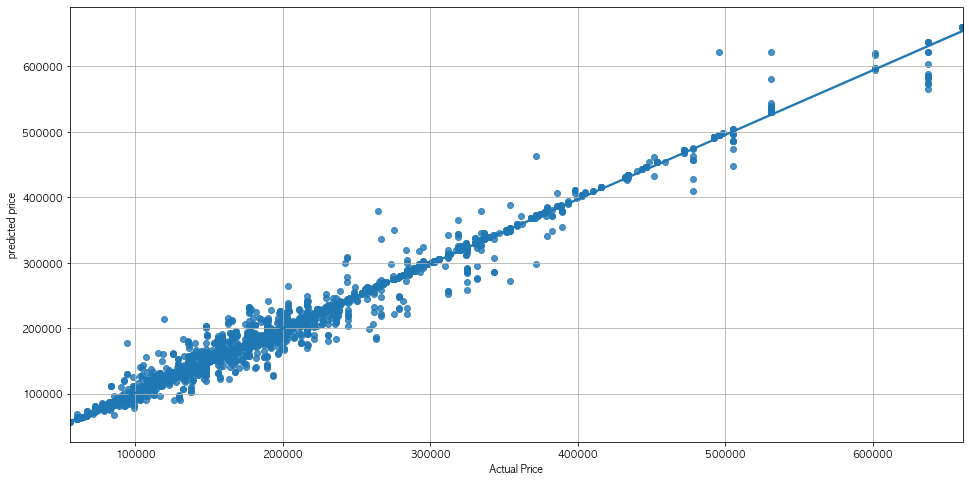

In [56]:
#실제값과 예측값 scatterplot
plt.figure(figsize=(16,8))
sns.regplot(y_test,pred_test,fit_reg=True)
plt.xlabel('Actual Price')
plt.ylabel('predicted price')
plt.grid()
plt.show();

In [60]:
# K-Fold
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

kfold =KFold(n_splits=5)
rf_cv = RandomForestRegressor()

# k-fold=5로 rmse값 보기
cv_rmse = []
for train_idx, test_idx in kfold.split(x):
    x_train_cv, x_test_cv = x.iloc[train_idx], x.iloc[test_idx] 
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    rf_cv.fit(x_train_cv,y_train_cv)
    pred_cv = rf_cv.predict(x_test_cv) 
    
    cv_rmse.append(np.sqrt(mean_squared_error(y_test_cv,pred_cv)))
    
print("cv_rmse : ", cv_rmse, end="\n")
print("cv_rmse_avg :",np.mean(cv_rmse))

cv_rmse :  [13687.731770219649, 25403.86869410418, 34925.20570628278, 23189.321797799726, 29927.510823448407]
cv_rmse_avg : 25426.727758370947


###  아쉬운점 및 배운점

- 여러가지 방식으로 데이터를 전처리를 시도하여 RMSE값을 10000이하로 낮춰보고자 했으나 잘 되지 않아 아쉬움이 크다.
- 차량의 렌트가격은 차량 자체의 가격으로부터 절대적인 영향을 받는다는 사실을 알게 됨.
- 모델의 성능을 높이기 위해 분석가로서 데이터셋의 비정상적인 수치를 아웃라이어라고 과감히 판단하는 결정이 어렵다는 점과 판단의 근거가 얼마나 중요한 지 깨닫게 됨